In [1]:
#import potrebnych kniznic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="The default of observed=False is deprecated", category=FutureWarning)
warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna, .ffill", category=FutureWarning)
warnings.filterwarnings("ignore", message="'n_jobs' > 1 does not have any effect", category=UserWarning)
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# stlpce ktore sme vyhodnoti ako kategoricke po preskumani excel suboru. Pandas automaticky vsetky hodnoty
# premiena, ktore nie su int/float premiena na object - ak vieme vsak ze su to kategoricke premenne
# a maju obmedzeny pocet moznych hodnot, je lepsie ich premenit na category
columns_to_category = ["Country", "NrOfDependants", "EmploymentDurationCurrentEmployer", "WorkExperience",
                        "VerificationType", "LanguageCode", 
                       "Gender", "UseOfLoan", "Education", "MaritalStatus", "EmploymentStatus", 
                       "OccupationArea", "HomeOwnershipType", "RecoveryStage", "ModelVersion", "Rating", 
                       "Rating_V0", "Rating_V1", "Rating_V2", "Status", "Restructured", "ActiveLateCategory",
                       "WorseLateCategory", "CreditScoreEsMicroL", "CreditScoreEsEquifaxRisk", 
                       "CreditScoreFiAsiakasTietoRiskGrade", "CreditScoreEeMini", "ActiveLateLastPaymentCategory",
                       ]

#nacitanie csv suborov do Pandas DataFrame, engine=pyarrow boost v rychlosti nacitania
## https://www.bondora.com/en/public-reports          dataset
dataLoan = pd.read_csv("LoanData/LoanData.csv",engine='pyarrow',dtype={column: "category" for column in columns_to_category})

#transformacia datumov na datetime typ - iba tie, ktore nebudu dropnute neskor , ,errors='coerce' znamena aby datumy, ktore nemozno konvertovat
#boli vyhodnotene ako NaT - Not a Time
dates=["MaturityDate_Original","MaturityDate_Last","LastPaymentOn","DebtOccuredOn",
       "GracePeriodStart","GracePeriodEnd","NextPaymentDate","ReScheduledOn","FirstPaymentDate"]
for date in dates:
    dataLoan[date] = pd.to_datetime(dataLoan[date],format='%d.%m.%Y',errors='coerce')

#vynechame stlpec ReportAsOfEOD –  reprezentuje deň(EOD – End Of Day)  kedy bol report vygenerovaný a Event, lebo Comment obsahuje vsetko info
## https://www.bondora.com/en/public-reports          dataset
dataDebt = pd.read_csv("DebtEvents/DebtEvents.csv",engine='pyarrow',usecols = ['LoanId','Comment'])

#vypis stlpcov v datasete dataLoan
dataLoan.columns.values

array(['ReportAsOfEOD', 'LoanId', 'LoanNumber', 'ListedOnUTC',
       'BiddingStartedOn', 'BidsPortfolioManager', 'BidsApi',
       'BidsManual', 'PartyId', 'NewCreditCustomer',
       'LoanApplicationStartedDate', 'LoanDate', 'ContractEndDate',
       'FirstPaymentDate', 'MaturityDate_Original', 'MaturityDate_Last',
       'ApplicationSignedHour', 'ApplicationSignedWeekday',
       'VerificationType', 'LanguageCode', 'Age', 'DateOfBirth', 'Gender',
       'Country', 'AppliedAmount', 'Amount', 'Interest', 'LoanDuration',
       'MonthlyPayment', 'County', 'City', 'UseOfLoan', 'Education',
       'MaritalStatus', 'NrOfDependants', 'EmploymentStatus',
       'EmploymentDurationCurrentEmployer', 'EmploymentPosition',
       'WorkExperience', 'OccupationArea', 'HomeOwnershipType',
       'IncomeFromPrincipalEmployer', 'IncomeFromPension',
       'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare',
       'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther',
       'IncomeTotal'

In [3]:
#pocet riadkov a sltpcov v dataLoan
dataLoan.shape

(375479, 112)

In [4]:
#pocet riadkov a sltpcov v dataDebt
dataDebt.shape

(3914009, 2)

In [5]:
#vytvorenie stlpcov pre Default - zlyhanie platby , Fraud - podozrenie na podvodnu ziadost, Explanation - zdovodnenie
#konvertovanie vsetkych novych stlpcov na kategoriu

#naplnenie Default stlpca podla stlpca "DefaultDate", ak doslo k defaultu, tak datum nebude NA. 
dataLoan["Default"] = 0
dataLoan.loc[dataLoan["DefaultDate"].notna() == True, "Default"] = 1
dataLoan['Default'] = dataLoan['Default'].astype('category')

#zaklane hodnoty stlpcov Fraud a Explanation
dataLoan["Fraud"] = 0

dataLoan['Fraud'] = dataLoan['Fraud'].astype(pd.CategoricalDtype(categories=[0, 1], ordered=True))

dataLoan["Explanation"] = 'Not a suspect'
dataLoan['Explanation'] = dataLoan['Explanation'].astype(pd.CategoricalDtype(
    categories=['90+ days overdue and paid zero payments',
                '90+ days overdue and paid less than 2 payments',
                '200+ days payment overdue without response and suspicious behaviour','Not a suspect'], ordered=False))


In [6]:
#podvodna ziadost podla podmienky cislo 1 a ich pocet

dataLoan.loc[(dataLoan.PrincipalPaymentsMade == 0) & (dataLoan.Default == 1),['Fraud','Explanation']] = [1,'90+ days overdue and paid zero payments']
print(len(dataLoan.loc[(dataLoan.PrincipalPaymentsMade == 0) & (dataLoan.Fraud == 1)]))

5510


In [7]:
#podvodna ziadost podla podmienky cislo 2 a ich pocet
print(len(dataLoan.loc[(dataLoan.PrincipalPaymentsMade < 2.0 * dataLoan.MonthlyPayment) & (dataLoan.Default == 1) & (dataLoan.Fraud != 1)]))
dataLoan.loc[(dataLoan.PrincipalPaymentsMade < 2.0 * dataLoan.MonthlyPayment) & (dataLoan.Default == 1),['Fraud','Explanation']] = [1,'90+ days overdue and paid less than 2 payments']



26490


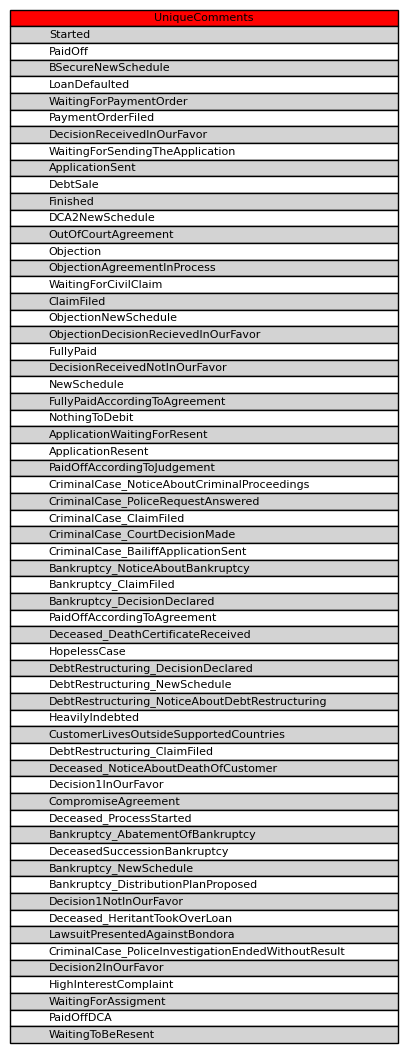

In [8]:
#Vytvorenie tabulky so vsetkymi unikatnymi komentarmi v datasete dataDebt
comments = pd.DataFrame(dataDebt.Comment.unique(),columns=["UniqueComments"])
fig, ax = plt.subplots(figsize=(5, 11))


cell_colors = [["lightgray" if i % 2 == 0 else "white"] for i in range(len(comments))]

ax.axis('off')
plt.savefig("uniqueComments.png", bbox_inches='tight')
ax.table(cellText=comments.values, colLabels=comments.columns, loc='center',colColours='red', cellColours= cell_colors, cellLoc='left' )


In [9]:
#Podvod podla podmienky cislo 3 a ich pocet
#regex na vyhladavanie v datasete dataDebt, kde sa zaznamenava vymahanie. V sus su komentare aktivit, ktore pokladame za podozrive
sus = ['CriminalCase','HopelessCase','HeavilyIndebted','CustomerLivesOutsideSupportedCountries','LawsuitPresentedAgainstBondora']
pattern = '|'.join(sus)

#vybrate unikatne id uverov ktore splnaju podmienky na podvod
dataSusID = dataDebt[dataDebt["Comment"].str.contains(pattern, case=False, na=False,regex=True)].LoanId.unique()
print(len(dataLoan.loc[dataLoan.LoanId.isin(dataSusID)  & (dataLoan.Fraud != 1)]))
#mozeme zahodit dataset dataDebt, potrebovali sme ho iba na urcenie zavislej premennej
dataDebt = None
dataLoan.loc[dataLoan.LoanId.isin(dataSusID), ['Fraud','Explanation']] = [1, '200+ days payment overdue without response and suspicious behaviour']



1515


In [10]:
#pocet riadkov v datasete dataLoan
dataLoan.shape[0]

375479

In [11]:
#pocet riadkov - ziadosti, ktore sme urcili ako podvodne
dataLoan.loc[dataLoan.Fraud == 1,:].shape[0]

33515

In [12]:
#percentualne vyjadrenie poctu podvodov voci vsetkym ziadostiam
dataLoan.loc[dataLoan.Fraud == 1,:].shape[0]/dataLoan.shape[0] * 100

8.92593194293156

In [13]:
#prehlad na hodnot v datasete
#zakomentovany riadok sluzi na zobrazenie vsetkych stlpcov
#pd.set_option("display.max_row" , None)
dataLoan.isna().sum().sort_index()

ActiveLateCategory                   240356
ActiveLateLastPaymentCategory        226129
ActiveScheduleFirstPaymentReached         0
Age                                       0
Amount                                    0
                                      ...  
Status                                    0
UseOfLoan                                 0
VerificationType                         50
WorkExperience                       338957
WorseLateCategory                    130065
Length: 115, dtype: int64

In [14]:
## niektore stlpce nemaju spravnu kategoriu lebo budu dropnute kvoli tomu, ze su uplne prazdne,napriklad County alebo City
def getInfo():
    dataLoan[sorted(dataLoan.columns)].info(verbose=True)
getInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375479 entries, 0 to 375478
Data columns (total 115 columns):
 #    Column                                  Dtype         
---   ------                                  -----         
 0    ActiveLateCategory                      category      
 1    ActiveLateLastPaymentCategory           category      
 2    ActiveScheduleFirstPaymentReached       bool          
 3    Age                                     int64         
 4    Amount                                  float64       
 5    AmountOfPreviousLoansBeforeLoan         float64       
 6    ApplicationSignedHour                   int64         
 7    ApplicationSignedWeekday                int64         
 8    AppliedAmount                           float64       
 9    BiddingStartedOn                        datetime64[s] 
 10   BidsApi                                 float64       
 11   BidsManual                              float64       
 12   BidsPortfolioManager        

In [15]:
##pomocny cyklus na vypis unikatnych hodnot v kazdom stlpci, na urcenie categorickych premennych, vyuzite hlavne pri nacitani, aby sme urcili kategoriu

for el in dataLoan.columns:
        qvalues = dataLoan[el].value_counts()
        
        print(f"Unikatne hodnoty v stlpci '{el}': {qvalues}")
        print("------")

Unikatne hodnoty v stlpci 'ReportAsOfEOD': ReportAsOfEOD
2024-04-04    375479
Name: count, dtype: int64
------
Unikatne hodnoty v stlpci 'LoanId': LoanId
D8EBF360-104C-420F-BEC9-000924E6EFC7    1
A818D954-BEF9-49D1-B3E0-AEE100EFCC20    1
107DE728-7536-4FB1-884B-AEE100EC39CA    1
16ACE9C1-E547-4D77-8CAB-AEE100E9BCF2    1
68521C28-818E-43B2-9249-AEE100E8ADD6    1
                                       ..
478CEF29-4A90-4E32-9F48-AB0900FA49AC    1
E2844253-BA7B-45AA-824B-AB0900F9514A    1
66563EA3-7E87-4E23-B41F-AB0900F8E220    1
5E4F5920-6A83-4052-B8FD-AB0900F8AAB5    1
430840D3-58C4-4651-88DE-FFF979D8D853    1
Name: count, Length: 375479, dtype: int64
------
Unikatne hodnoty v stlpci 'LoanNumber': LoanNumber
3015853    1
2944919    1
2944898    1
2944874    1
2944866    1
          ..
1660113    1
1660105    1
1660095    1
1660091    1
3631332    1
Name: count, Length: 375479, dtype: int64
------
Unikatne hodnoty v stlpci 'ListedOnUTC': ListedOnUTC
2021-04-26 07:26:37    4
2021-04-29 09:

In [16]:
#DateOfBirth, County, City, EmploymentPosition su prazdne v celom datasete
naArray = [i for i in dataLoan.columns if dataLoan[i].isna().mean() >= 1]
dataLoan.drop(labels=naArray,axis=1, inplace=True)

print(naArray)

['DateOfBirth', 'County', 'City', 'EmploymentPosition']


In [17]:
##konvertovanie datumov dlzku intervalu medzi nimi
dataLoan['DeltaGracePeriod'] = (dataLoan['GracePeriodEnd'] - dataLoan['GracePeriodStart']).dt.days
dataLoan['DeltaMaturityDate'] = (dataLoan['MaturityDate_Last'] - dataLoan['MaturityDate_Original']).dt.days
dataLoan['DeltaF&LPayment'] = (dataLoan['LastPaymentOn'] - dataLoan['FirstPaymentDate']).dt.days
dataLoan['DeltaBidding&DebtOccured'] = (dataLoan['DebtOccuredOn'] - dataLoan['BiddingStartedOn']).dt.days
#True ak dlnzik zmenil termin splatky alebo nie
dataLoan["Rescheduled"] = ~dataLoan["ReScheduledOn"].isna()
dataLoan["Rescheduled"]

0          True
1          True
2         False
3         False
4         False
          ...  
375474    False
375475    False
375476     True
375477     True
375478    False
Name: Rescheduled, Length: 375479, dtype: bool

In [18]:
getInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375479 entries, 0 to 375478
Data columns (total 116 columns):
 #    Column                                  Dtype         
---   ------                                  -----         
 0    ActiveLateCategory                      category      
 1    ActiveLateLastPaymentCategory           category      
 2    ActiveScheduleFirstPaymentReached       bool          
 3    Age                                     int64         
 4    Amount                                  float64       
 5    AmountOfPreviousLoansBeforeLoan         float64       
 6    ApplicationSignedHour                   int64         
 7    ApplicationSignedWeekday                int64         
 8    AppliedAmount                           float64       
 9    BiddingStartedOn                        datetime64[s] 
 10   BidsApi                                 float64       
 11   BidsManual                              float64       
 12   BidsPortfolioManager        

In [19]:
#vypis stlpcov ktore maju 90% hodnot
print([i for i in dataLoan.columns if dataLoan[i].isna().mean() >= 0.90])

['NrOfDependants', 'WorkExperience', 'EL_V0', 'Rating_V0', 'EL_V1', 'Rating_V1', 'Rating_V2', 'CreditScoreEsEquifaxRisk']


In [20]:
## Vsetky ratingy maju rovnake kategorie hodnotenia
print(sorted(dataLoan.loc[dataLoan["Rating"].notna(),"Rating"].values.unique().tolist()))
print(sorted(dataLoan.loc[dataLoan["Rating_V0"].notna(),"Rating_V0"].values.unique().tolist()))
print(sorted(dataLoan.loc[dataLoan["Rating_V1"].notna(),"Rating_V1"].values.unique().tolist()))
print(sorted(dataLoan.loc[dataLoan["Rating_V2"].notna(),"Rating_V2"].values.unique().tolist()))

['A', 'AA', 'B', 'C', 'D', 'E', 'F', 'HR']
['A', 'AA', 'B', 'C', 'D', 'E', 'F', 'HR']
['A', 'AA', 'B', 'C', 'D', 'E', 'F', 'HR']
['A', 'AA', 'B', 'C', 'D', 'E', 'F', 'HR']


In [21]:
#pocet prazdnych hodnot v Rating
dataLoan.Rating.isna().sum()

2733

In [22]:
## Rating_V0, Rating_V1,Rating_V2 maju vela prazdnych hodonot, skombinujeme ich do jedneho, priorita Rating_V2>Rating_V1>Rating_V0>Rating
temp_series = dataLoan['Rating_V2'].fillna(dataLoan['Rating_V1']).fillna(dataLoan['Rating_V0'])
print(f"Pocet hodnot zlucenim Rating_V2, V1,V0 = {temp_series.notna().sum()}")
dataLoan['Rating'] = dataLoan['Rating'].where(temp_series.isna(), other=temp_series)
#pocet prazdnych po doplneni
print(f"Pocet prazdnych hodnov v Rating= {dataLoan.Rating.isna().sum()}")

Pocet hodnot zlucenim Rating_V2, V1,V0 = 25455
Pocet prazdnych hodnov v Rating= 2717


In [23]:
#Obdobnu vec spravime pre EL, na hodnot je aj tak prilis vela, treba dalsie spracovanie
dataLoan['Combined_EL'] = dataLoan['EL_V1'].fillna(dataLoan['EL_V0'])
dataLoan['Combined_EL'].isna().sum()

357986

In [24]:
# stlpce, ktore sme urcili, ze nemaju dalej vypovednu hodnotu pre nas k urcovani fraud
dataLoan.drop(["ReportAsOfEOD","ContractEndDate","LoanDate","BiddingStartedOn","BidsPortfolioManager","BidsApi",
               "BidsManual","PartyId","DefaultDate","NextPaymentDate","DebtOccuredOnForSecondary","ListedOnUTC","MaturityDate_Last",
               "MaturityDate_Original","GracePeriodEnd","GracePeriodStart","CurrentDebtDaysSecondary",
               "LoanApplicationStartedDate","FirstPaymentDate","StageActiveSince","DebtOccuredOn","ReScheduledOn","LastPaymentOn",
               "LoanId","EL_V0","EL_V1","Rating_V0","Rating_V1","Rating_V2","LoanNumber"],axis=1, inplace=True,)


# a este vyssie vymazane ['DateOfBirth', 'County', 'City', 'EmploymentPosition']

#LoanDate obsahuje nezmyselne udaje, plne ho nahradzuje LoanApplicationStartedDate vo vsetkych relevantnych udajoch

In [25]:
# Nasledne sa pokusim doplnit
# WorkExperience - baseline podla EmploymentDurationCurrentEmployer, potom statisticky
# CreditScoreEsEquifaxRisk - ine credit score firmy, dat average podla najfrekventovanejsieho Ratingu/Combined Ratingu
# Combined_EL average pre konkretny Rating/Combined Ratingu


print([i for i in dataLoan.columns if dataLoan[i].isna().mean() >= 0.90])

['NrOfDependants', 'WorkExperience', 'CreditScoreEsEquifaxRisk', 'Combined_EL']


In [26]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
getInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375479 entries, 0 to 375478
Data columns (total 87 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   ActiveLateCategory                      135123 non-null  category
 1   ActiveLateLastPaymentCategory           149350 non-null  category
 2   ActiveScheduleFirstPaymentReached       375479 non-null  bool    
 3   Age                                     375479 non-null  int64   
 4   Amount                                  375479 non-null  float64 
 5   AmountOfPreviousLoansBeforeLoan         375466 non-null  float64 
 6   ApplicationSignedHour                   375479 non-null  int64   
 7   ApplicationSignedWeekday                375479 non-null  int64   
 8   AppliedAmount                           375479 non-null  float64 
 9   Combined_EL                             17493 non-null   float64 
 10  Country                         

In [27]:
print(f"WorkExperience = {round((dataLoan['WorkExperience'].isna()).mean() * 100,2)}% missing.")
print(f"NrOfDependants = {round((dataLoan['NrOfDependants'].isna()).mean() * 100,2)}% missing.")
print(f"Combined_EL = {round((dataLoan['Combined_EL'].isna()).mean() * 100,2)}% missing.")
print(f"MaritalStatus = {round((dataLoan['MaritalStatus'] == -1).mean() * 100,2)}% missing.")
print(f"OccupationArea = {round((dataLoan['OccupationArea'] == -1).mean() * 100,2)}% missing.")
print(f"UseOfLoan = {round((dataLoan['UseOfLoan'] == -1).mean() * 100,2)}% missing.")

WorkExperience = 90.27% missing.
NrOfDependants = 90.52% missing.
Combined_EL = 95.34% missing.
MaritalStatus = 90.26% missing.
OccupationArea = 90.27% missing.
UseOfLoan = 90.26% missing.


In [28]:
##neexistuju zaznamy, kde by som vedel odhadnut marital status podla inych vlasnosti 
##pokus ziskat informacie o stave podla prijmu z roznych socialnych prispevkov (prispevky na deti, alimenty..)
len(dataLoan.loc[(dataLoan.MaritalStatus == -1 ) & ((dataLoan.IncomeFromChildSupport > 0) 
          | (dataLoan.IncomeFromFamilyAllowance > 0) | (dataLoan.IncomeFromSocialWelfare > 0)),["MaritalStatus","IncomeFromChildSupport",
                                                                                               "IncomeFromFamilyAllowance","IncomeFromSocialWelfare"]])


7187

In [29]:
## zahadzujem stlpce kde chyba vyse 90% hodnot
# doplnenie WorkExperience neuspesne, prilis vela NA a  odhad pomocou EmploymentDurationCurrentEmployer nesmerodajny kvoli vysokym poctom NA
dataLoan = dataLoan.drop(['MaritalStatus', 'NrOfDependants','OccupationArea','UseOfLoan','WorkExperience','Combined_EL'], axis=1)

In [30]:

##spracovanie kategorickych premennych
##vypis pocetnosti jednotlivych kategorii nezavislej premennej

for column in sorted(dataLoan.select_dtypes(include=['category'])):
    print(f"{dataLoan.groupby(column,observed=False).size()}")
    print(f"\nAnd there is {dataLoan[column].isna().sum()} missing values")
    print("---------------------------------------------------------------------")


ActiveLateCategory
1-7          4934
121-150      1984
151-180      1946
16-30        5887
180+       109296
31-60        4205
61-90        2347
8-15         2499
91-120       2025
dtype: int64

And there is 240356 missing values
---------------------------------------------------------------------
ActiveLateLastPaymentCategory
1-7         7051
121-150     3860
151-180     3323
16-30      18457
180+       84172
31-60      11030
61-90       6165
8-15       10698
91-120      4594
dtype: int64

And there is 226129 missing values
---------------------------------------------------------------------
Country
EE    170357
ES     31111
FI    166259
NL      7456
SK       296
dtype: int64

And there is 0 missing values
---------------------------------------------------------------------
CreditScoreEeMini
0.00            3
0.21           11
0.87            1
500.00         77
600.00       7386
700.00       6897
800.00      13853
900.00      15625
1000.00    120688
dtype: int64

And there is 2109

In [31]:

#transformacia NA hodnout v stlpcoch ulozenych v input_zero_imputer na '0' hodnotu. Musim znova pretypovat na cateegory, lebo imputer ich vracia na objekt
###ActiveLateCategory, ActiveLateLastPaymentCategory , '0' znamena ze neboli late

from sklearn.impute import SimpleImputer
zero_imputer = SimpleImputer(strategy="constant",fill_value='0')
input_zero_imputer = ["ActiveLateCategory","ActiveLateLastPaymentCategory","WorseLateCategory"]


dataLoan[input_zero_imputer] = zero_imputer.fit_transform(dataLoan[input_zero_imputer])
for el in input_zero_imputer:
    dataLoan[el] = dataLoan[el].astype("category")



### RecoveryStage ma podla legendy urcite stavy, ktore su zakodovane podlsa cisla
### urcujem 0 ako stav, kedy este nedoslo k vyskytu RecoveryStage. RecoveryStage je typu object namiesto number, preto musim osobitne 
dataLoan["RecoveryStage"] = dataLoan["RecoveryStage"].cat.add_categories([0])
dataLoan["RecoveryStage"] = dataLoan["RecoveryStage"].fillna(0)

In [32]:
dataLoan.shape

(375479, 81)

In [33]:
#Education obsahuje hodnoty -1 a 0, ktore nie su v legende.
# urcujem 0 ako "nezname/neuvedene vzdelanie"
dataLoan.loc[(dataLoan["Education"] ==-1) | (dataLoan["Education"].isna()),"Education"] = 0
dataLoan["Education"] = dataLoan["Education"].cat.remove_categories([-1])

In [34]:
#Education obsahuje hodnoty -1 a 0, ktore nie su v legende.
#taktiez datasete sa nenachadza 1, ktora by mala znamenat unemployed. Preto menim 0, ktorych je iba 32 na 1ku, co je kvalifikovany odhad
# kategoriu 1 musim pridat lebo nie je pritomna
# a dalej urcujem 0 ako "neznamy/neuvedeny" stav


dataLoan["EmploymentStatus"] = dataLoan["EmploymentStatus"].cat.add_categories([1])
dataLoan.loc[(dataLoan["EmploymentStatus"] ==0),"EmploymentStatus"] = 1
dataLoan.loc[(dataLoan["EmploymentStatus"] ==-1) | (dataLoan["EmploymentStatus"].isna()),"EmploymentStatus"] = 0

## 282556 hodnot doplnenych. odhadujeme, ze ak EmploymentDurationCurrentEmployer nie je NA, tak je ziadatel zamestnany na plny uvazok
dataLoan.loc[(dataLoan["EmploymentStatus"] == 0) & 
((dataLoan["EmploymentDurationCurrentEmployer"].notna()) & (dataLoan["EmploymentDurationCurrentEmployer"] != "Retiree")
 & (dataLoan["EmploymentDurationCurrentEmployer"] != "Other")),"EmploymentStatus"] =3

dataLoan["EmploymentStatus"] = dataLoan["EmploymentStatus"].cat.remove_categories([-1])

### kvalifikovany odhad, ak EmploymentDurationCurrentEmployer je prazdna a EmploymentStatus je iny ako neznamy, NA alebo bez zamestnania
# tak nastav ako "UpTo5Years". 715 hodnot
dataLoan.loc[(dataLoan["EmploymentDurationCurrentEmployer"].isna()) 
& (dataLoan["EmploymentStatus"].notna()) &  (dataLoan["EmploymentStatus"] != 1) & (dataLoan["EmploymentStatus"] != 0),"EmploymentDurationCurrentEmployer"] = "UpTo5Years"


In [35]:
dataLoan.loc[(dataLoan["Gender"].isna()),"Gender"] = 2

In [36]:
#odstran vsetky na hodnoty lebo nemam ako ich odhadnut a nie je ich vela
#odstranim aj zaznamy, kde je vyplnene -1, lebo takato hodnotav legende nie je
#1660 hodnot
dataLoan.dropna(subset=['HomeOwnershipType'],inplace=True)
dataLoan = dataLoan.loc[(dataLoan["HomeOwnershipType"] !=-1)]
dataLoan["HomeOwnershipType"] = dataLoan["HomeOwnershipType"].cat.remove_categories([-1])

In [37]:
##LanguageCode - legenda je nekompletna, v datasete su cody, ktore nie su vysvetlene.
## okrem kodu 19, by som mohol riesit dropnutim. Kod 19 je podla datovej analyzi pravdepodobne holandcina, lebo krajina ziadatela je vzdy NL
## odsranili sme 17 hodnot
print(dataLoan.loc[(dataLoan["LanguageCode"] ==19),"Country"].unique())
dataLoan = dataLoan[(dataLoan['LanguageCode'].map(dataLoan['LanguageCode'].value_counts()) > 50) | (dataLoan['LanguageCode'] == 5)]
dataLoan["LanguageCode"] = dataLoan["LanguageCode"].cat.remove_unused_categories()



['NL']
Categories (5, object): ['EE', 'ES', 'FI', 'NL', 'SK']


In [38]:
#nie su podrobne popisane verzie modelu, ale kvalifikovany odhad hovori ze model 0.0 je neuplatneny ziaden model na 
# urcenie ratingu, preto vsetky NA menim na 0
dataLoan.loc[(dataLoan["ModelVersion"].isna()) ,"ModelVersion"] = 0

In [39]:
##Rating ma iba 1062 NA hodnot a nemame dobry sposob ako ich odhadnut, preto tuto malu vzorku dropnem
dataLoan.dropna(subset=['Rating'],inplace=True)

In [40]:
#dropnem zazanmy, kde ich je den splatky 0, bolo ich 30
dataLoan = dataLoan[dataLoan['MonthlyPaymentDay'] != 0]

In [41]:
#vytvorenie pola a pridanie kategorii na ktore budeme rozdelovat, pre kazdy stlpec
creditArr = ['CreditScoreEeMini', 'CreditScoreEsEquifaxRisk', 'CreditScoreEsMicroL', 'CreditScoreFiAsiakasTietoRiskGrade']
for el in creditArr:
    dataLoan[el] = dataLoan[el].cat.add_categories(["Very Low","Low","Average","High","Very High"])

#vymazanie hodnot v CreditScoreEeMini ktore nie su vysvetlene v legende
dataLoan = dataLoan[~dataLoan["CreditScoreEeMini"].isin([0.00,0.21,0.87])]
mini={
    1000: 'Very Low',
    900: 'Low',
    800: 'Average', 
    700: 'High', 
    600: 'Very High', 500: 'Very High'
}
#hodnota M sa nenachadza v legende, nahradim ju na
dataLoan.loc[dataLoan['CreditScoreEsMicroL'] =="M", 'CreditScoreEsMicroL'] = pd.NA
micro = {
    'M1': 'Very Low', 'M2': 'Very Low', 
    'M3': 'Low', 'M4': 'Low',
    'M5': 'Average', 'M6': 'Average', 
    'M7': 'High', 'M8': 'High',
    'M9': 'Very High', 'M10': 'Very High'
}

equifax={
    'AAA': 'Very Low',
    'AA': 'Very Low',
    'A': 'Low', 
    'B': 'Average', 
    'C': 'High', 
    'D': 'Very High'
}

##zlucujem 1 a 2 a 6 a 7.... 8micku mazeme, lebo nevieme priradit a je ich malo
dataLoan = dataLoan[~dataLoan["CreditScoreFiAsiakasTietoRiskGrade"].isin([8])]
asiakas = {
    'RL1': 'Very Low','1': 'Very Low','2': 'Very Low',
    'RL2': 'Low','3': 'Low',
    'RL3': 'Average', '4': 'Average',
    'RL4': 'High', '5': 'High',
    'RL5': 'Very High','6': 'Very High','7': 'Very High'
}
## premena povodnych hodnot na nasu novu skalu ["Very Low","Low","Average","High","Very High"]
dataLoan['CreditScoreEsMicroL'] = dataLoan['CreditScoreEsMicroL'].map(micro)
dataLoan['CreditScoreEeMini'] = dataLoan['CreditScoreEeMini'].map(mini)
dataLoan['CreditScoreEsEquifaxRisk'] = dataLoan['CreditScoreEsEquifaxRisk'].map(equifax)
dataLoan['CreditScoreFiAsiakasTietoRiskGrade'] = dataLoan['CreditScoreFiAsiakasTietoRiskGrade'].map(asiakas)

### CreditScoreEsMicroL ma prednost, lebo 'specifically designed for risk classifying subprime borrowers' a najmenej som si domyslal, iba som podelil 2ma
### CreditScoreEsEquifaxRisk tu som iba zlucil average a average high preto je dalsi v poradi
### CreditScoreEeMini tu som si nedomyslal ale je ich najviac vyplnenych takze nevyuzil by som ostatne, kedze sa doplnaju iba nevyplnene predchodcami
### CreditScoreFiAsiakasTietoRiskGrade posledne, lebo som si najviac domyslal, spajal som a este aj odhadoval co znamenaju hodnoty, nedostatocna legenda
dataLoan['CreditScoreUnified'] = dataLoan['CreditScoreEsMicroL'].combine_first(dataLoan['CreditScoreEsEquifaxRisk'])
dataLoan['CreditScoreUnified'] = dataLoan['CreditScoreUnified'].combine_first(dataLoan['CreditScoreEeMini'])
dataLoan['CreditScoreUnified'] = dataLoan['CreditScoreUnified'].combine_first(dataLoan['CreditScoreFiAsiakasTietoRiskGrade'])
dataLoan['CreditScoreUnified'] = pd.Categorical(dataLoan['CreditScoreUnified'],categories=["Very Low", "Low", "Average", "Not Rated","High", "Very High"],
                ordered=True)


### vysledkom je 29665 NA hodnot, cca 8% z momentalnej velkosti
len(dataLoan.loc[dataLoan['CreditScoreUnified'].isna() == True]) /dataLoan.shape[0] * 100

dataLoan["CreditScoreUnified"] = dataLoan["CreditScoreUnified"].fillna('Not Rated')


### zahodim credit score stlpce ktore su uz teraz vyjadrene pomocou CreditScoreUnified
dataLoan = dataLoan.drop(['CreditScoreEsMicroL', 'CreditScoreEsEquifaxRisk','CreditScoreEeMini','CreditScoreFiAsiakasTietoRiskGrade'], axis=1)

In [42]:
#sort podla poctu chybajuci hodnot
def getNA():
    return dataLoan.isna().sum().sort_values(ascending=False)
getNA()

PlannedPrincipalTillDate                  320965
PreviousEarlyRepaymentsBefoleLoan         313330
DeltaGracePeriod                          273458
InterestAndPenaltyWriteOffs               263428
PrincipalDebtServicingCost                263428
PrincipalWriteOffs                        263428
InterestAndPenaltyDebtServicingCost       263428
EAD2                                      252377
EAD1                                      252377
InterestRecovery                          252375
PlannedPrincipalPostDefault               252375
PlannedInterestPostDefault                252375
PrincipalRecovery                         252375
DeltaBidding&DebtOccured                  235062
CurrentDebtDaysPrimary                    235062
InterestAndPenaltyBalance                 201413
NrOfScheduledPayments                     171729
NextPaymentNr                             171729
PreviousRepaymentsBeforeLoan              143026
PrincipalOverdueBySchedule                 12438
EmploymentDurationCu

In [43]:
#kontrola stlpcov, ci ma zmizel v nich mat zaporne hodnoty podla legendy
def printNegativeOrZero():
    for column in dataLoan.columns:
        if dataLoan[column].dtype in ['int64', 'float64']:
            if any(dataLoan[column] < 0):
                print(f"Column '{column}' contains a negative number. {(dataLoan[column] < 0).sum()}")
printNegativeOrZero()

Column 'FreeCash' contains a negative number. 13
Column 'ExpectedReturn' contains a negative number. 3243
Column 'EAD2' contains a negative number. 6185
Column 'PrincipalBalance' contains a negative number. 6
Column 'InterestAndPenaltyBalance' contains a negative number. 12
Column 'DeltaMaturityDate' contains a negative number. 20783
Column 'DeltaF&LPayment' contains a negative number. 10697


In [44]:
## nedava zmysel podla legendy, aby tieto hodnoty boli negativne
dataLoan = dataLoan[(dataLoan['PrincipalBalance'] >= 0) |(dataLoan['PrincipalBalance'].isna()) ]
dataLoan =  dataLoan[(dataLoan['InterestAndPenaltyBalance'] >= 0) |(dataLoan['InterestAndPenaltyBalance'].isna())]

In [45]:
#OK
printNegativeOrZero()

Column 'FreeCash' contains a negative number. 13
Column 'ExpectedReturn' contains a negative number. 3243
Column 'EAD2' contains a negative number. 6185
Column 'DeltaMaturityDate' contains a negative number. 20783
Column 'DeltaF&LPayment' contains a negative number. 10697


In [46]:
dataLoan.shape

(372679, 78)

In [47]:
##zaciname s najmenej chybajucimi

## nemozno odvodit, preto dropujem riadky s na hodnotami
print(f"NoOfPreviousLoansBeforeLoan a  NoOfPreviousLoansBeforeLoan prienik {len(dataLoan.loc[(
(dataLoan["NoOfPreviousLoansBeforeLoan"].isna()) 
& (dataLoan["NoOfPreviousLoansBeforeLoan"].notna())) |
((dataLoan["NoOfPreviousLoansBeforeLoan"].notna())&
 (dataLoan["NoOfPreviousLoansBeforeLoan"].isna()))])} hodnot")

#dropnem aj ostatne, nedaju sa odvodit a  chyba malo hodnot

# dataLoan.dropna(subset=['DeltaMaturityDate','AmountOfPreviousLoansBeforeLoan','PreviousEarlyRepaymentsCountBeforeLoan',
# 'NoOfPreviousLoansBeforeLoan','ProbabilityOfDefault','LossGivenDefault',
# 'ExpectedLoss','ExpectedReturn','DeltaMaturityDate'],inplace=True)                

dataLoan.dropna(subset=[column for column in dataLoan.columns.values if dataLoan[column].isna().sum() < 10],inplace=True)      

NoOfPreviousLoansBeforeLoan a  NoOfPreviousLoansBeforeLoan prienik 0 hodnot


In [48]:
getNA()

PlannedPrincipalTillDate                  320952
PreviousEarlyRepaymentsBefoleLoan         313321
DeltaGracePeriod                          273431
PrincipalWriteOffs                        263418
InterestAndPenaltyDebtServicingCost       263418
PrincipalDebtServicingCost                263418
InterestAndPenaltyWriteOffs               263418
EAD2                                      252346
EAD1                                      252346
InterestRecovery                          252344
PrincipalRecovery                         252344
PlannedPrincipalPostDefault               252344
PlannedInterestPostDefault                252344
DeltaBidding&DebtOccured                  235030
CurrentDebtDaysPrimary                    235030
InterestAndPenaltyBalance                 201406
NrOfScheduledPayments                     171695
NextPaymentNr                             171695
PreviousRepaymentsBeforeLoan              143018
PrincipalOverdueBySchedule                 12418
EmploymentDurationCu

In [49]:
# stlpce kde je aspon 70% NA
print([i for i in dataLoan.columns if dataLoan[i].isna().mean() >= 0.70])

['PlannedPrincipalTillDate', 'PrincipalWriteOffs', 'InterestAndPenaltyWriteOffs', 'PreviousEarlyRepaymentsBefoleLoan', 'PrincipalDebtServicingCost', 'InterestAndPenaltyDebtServicingCost', 'DeltaGracePeriod']


In [50]:
#PrincipalWriteOffs a InterestAndPenaltyWriteOffs, DeltaGracePeriod premenim na True/ False

dataLoan["HadWriteOffs"] = False
dataLoan.loc[(dataLoan["PrincipalWriteOffs"].notna()) | (dataLoan["InterestAndPenaltyWriteOffs"].notna()),'HadWriteOffs'] = True

dataLoan["HadGracePeriod"] = False
dataLoan.loc[dataLoan["HadGracePeriod"].notna(),'HadGracePeriod'] = True


dataLoan.drop(['PrincipalWriteOffs','InterestAndPenaltyWriteOffs','DeltaGracePeriod'],inplace=True,axis=1)



In [51]:
## 'PlannedPrincipalTillDate', 'PreviousEarlyRepaymentsBefoleLoan', 'PrincipalDebtServicingCost', 'InterestAndPenaltyDebtServicingCost'
##### PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost nerelevantne pre nas, cena pre Bondoru po vymahani
##dropnem zvysne, lebo nevieme ich doplnit a 
#v pripade PreviousEarlyRepaymentsBefoleLoan dokazem ziskat aspon ci mal podla PreviousEarlyRepaymentsCountBeforeLoan
dataLoan.drop([i for i in dataLoan.columns if dataLoan[i].isna().mean() >= 0.70],inplace=True,axis=1)

In [52]:
#EAD1 a EAD2 mozem dropnut nemam ako ziskat a nedaju sa navzajom doplnit
#PrincipalRecovery nerelevantne k odhadovaniu podvodov
#InterestRecovery  nerelevantne k odhadovaniu podvodov
#PlannedInterestPostDefault, PlannedPrincipalPostDefault nie je mozno doplniit
#PrincipalRecovery,InterestRecovery,PlannedInterestPostDefault,PlannedPrincipalPostDefault
#^ su zavisle na EAD1 a EAD2, ak je NA tak aj tieto

#tu potvrdzujem moju teoriu, ze su na sebe zavisle, vysledok je,ze iba v 8 pripadoch sa v jednom z danych stlpcov
#nachadza nejaka hodnota, ked v ostatnych je NA
columns = ['EAD1', 'EAD2', 'PlannedPrincipalPostDefault', 'PrincipalRecovery', 'PlannedInterestPostDefault', 'InterestRecovery']
total_sum = 0

for col in columns:
    other_cols = [c for c in columns if c != col]
    res = dataLoan[col].notna() & dataLoan[other_cols].isna().any(axis=1)
    total_sum += res.sum()

print(f"Pocet hodnôt, ktoré su aspon v jednom z danych stlpcov not NA, a ostatne su NA - zjednotenie: {total_sum}")

Pocet hodnôt, ktoré su aspon v jednom z danych stlpcov not NA, a ostatne su NA - zjednotenie: 8


In [53]:
dataLoan.drop(['EAD1','EAD2','PlannedPrincipalPostDefault','PlannedInterestPostDefault',
                       'PrincipalRecovery','InterestRecovery'],inplace=True,axis=1)

In [54]:
##PreviousRepaymentsBeforeLoan mozeme dropnut - hodnoty iba, mam zaznamy o pocte splatenych predtym v inom stlpci
## CurrentDebtDaysPrimary sa neda doplnit, 
#InterestAndPenaltyBalance tiez dropneme, nevidime sposob na doplnenie

dataLoan.drop(['PreviousRepaymentsBeforeLoan','CurrentDebtDaysPrimary','InterestAndPenaltyBalance'],inplace=True,axis=1)

### transformacia DeltaBidding&DebtOccured na boolean hodnotu DebtOccured,
# ci vznikol debt alebo nie. Podla logiky, ak nastal Debault, musel nastat aj debt
dataLoan["DebtOccured"] = False
dataLoan.loc[(dataLoan["DeltaBidding&DebtOccured"].notna()) | (dataLoan["Default"] == 1),"DebtOccured"] = True
dataLoan.drop(["DeltaBidding&DebtOccured"],inplace=True,axis=1)

In [55]:
#NrOfScheduledPayments doplnim nezname hodnoty podla LoanDuration pre dosiahnute dostatocneho odhadu
dataLoan.loc[dataLoan["NrOfScheduledPayments"].isna(),"NrOfScheduledPayments"] = dataLoan["LoanDuration"]

In [56]:
dataLoan["NextPaymentNr"].describe()

count    200968.000000
mean          5.454764
std           8.137792
min           0.000000
25%           0.000000
50%           3.000000
75%           8.000000
max          60.000000
Name: NextPaymentNr, dtype: float64

In [57]:
(dataLoan[dataLoan['NextPaymentNr'] != 0]['NextPaymentNr']).describe()

count    139918.000000
mean          7.834825
std           8.744801
min           1.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          60.000000
Name: NextPaymentNr, dtype: float64

In [58]:
#### zistili sme ze 0 je specialny pripad, ktory sa nastavy, ked dojde k defaultu
dataLoan.loc[dataLoan["NextPaymentNr"] == 0,["NextPaymentNr","Default"]].sample(20)

,NextPaymentNr,Default
219388,0.0,1
126191,0.0,1
98140,0.0,1
283523,0.0,1
106376,0.0,1
74023,0.0,1
126224,0.0,1
139568,0.0,1
269972,0.0,1
301519,0.0,1


In [59]:
##preto za NA hodnoty dosadime ciselnu charakteristiku median 
#dobry kompromis a redukuje vplyv outliers a vysoku std
medianNextPaymentNrs =  (dataLoan[dataLoan['NextPaymentNr'] != 0]['NextPaymentNr']).median()
dataLoan.loc[dataLoan["NextPaymentNr"].isna(),"NextPaymentNr"] = medianNextPaymentNrs

In [60]:
getNA()

PrincipalOverdueBySchedule                12418
EmploymentDurationCurrentEmployer         10277
DeltaF&LPayment                            9889
PlannedInterestTillDate                    4603
MonthlyPayment                             4046
Restructured                                  0
InterestAndPenaltyPaymentsMade                0
PrincipalPaymentsMade                         0
WorseLateCategory                             0
ActiveLateCategory                            0
Status                                        0
NoOfPreviousLoansBeforeLoan                   0
Rating                                        0
ModelVersion                                  0
RecoveryStage                                 0
ProbabilityOfDefault                          0
ExpectedReturn                                0
PrincipalBalance                              0
PreviousEarlyRepaymentsCountBeforeLoan        0
AmountOfPreviousLoansBeforeLoan               0
ExpectedLoss                            

In [61]:
## dropnutie zaznamov ktore neviem doplnit a su na
dataLoan.dropna(subset=['PrincipalOverdueBySchedule',
                        'PlannedInterestTillDate',
                       'DeltaF&LPayment','MonthlyPayment'],inplace=True)


In [62]:
### kvalifikovany odhad, ze ti co nemaju zamestnavatela  alebo nechceli prezradit su pod Other
dataLoan["EmploymentDurationCurrentEmployer"] = dataLoan["EmploymentDurationCurrentEmployer"].fillna('Other')

In [63]:
### transformacia novych stlpcov a stlpcov ktore mali cislo namiesto stringu ako 
### underlyting typ na category (potrebne pri encodingu)
dataLoan['VerificationType'] = dataLoan['VerificationType'].astype(str).astype('category')
dataLoan['Education'] = dataLoan['Education'].astype(str).astype('category')

dataLoan['ActiveScheduleFirstPaymentReached'] = dataLoan['ActiveScheduleFirstPaymentReached'].astype('category')
dataLoan['NewCreditCustomer'] = dataLoan['NewCreditCustomer'].astype('category')
dataLoan['HadWriteOffs'] = dataLoan['HadWriteOffs'].astype('category')
dataLoan['Rescheduled'] = dataLoan['Rescheduled'].astype('category')
dataLoan['HadGracePeriod'] = dataLoan['HadGracePeriod'].astype('category')
dataLoan['DebtOccured'] = dataLoan['DebtOccured'].astype('category')

In [64]:
dataLoan.head()

,NewCreditCustomer,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,LanguageCode,Age,Gender,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,Education,EmploymentStatus,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,MonthlyPaymentDay,ActiveScheduleFirstPaymentReached,PlannedInterestTillDate,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,PrincipalOverdueBySchedule,RecoveryStage,ModelVersion,Rating,Status,Restructured,ActiveLateCategory,WorseLateCategory,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,ActiveLateLastPaymentCategory,Default,Fraud,Explanation,DeltaMaturityDate,DeltaF&LPayment,Rescheduled,CreditScoreUnified,HadWriteOffs,HadGracePeriod,DebtOccured
0,False,12,6,4.0,1,27,1.0,EE,3189.0,3189.0,35.48,60,115.34,3.0,3.0,UpTo5Years,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,0,0.00,0,0.00,0.00,7,True,373.84,0.106489,0.664726,0.136812,0.160200,0.00,1.0,6.0,D,Current,False,0,8-15,817.61,1394.7100,2371.39,1.0,3402.0,0.0,5.0,23.0,0,0,0,Not a suspect,-680.0,543.0,True,Very Low,False,True,False
1,False,23,4,4.0,4,35,1.0,FI,4146.0,4146.0,19.86,60,108.17,5.0,3.0,UpTo5Years,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100.0,0,0.00,0,0.00,0.00,3,True,255.58,0.030048,0.760044,0.138239,0.039534,24.83,1.0,0.0,B,Late,True,31-60,31-60,272.34,493.8575,3873.66,1.0,518.0,0.0,10.0,120.0,61-90,0,0,Not a suspect,1881.0,235.0,True,Low,False,True,True
2,False,17,6,4.0,1,23,0.0,EE,531.0,531.0,19.52,60,15.25,5.0,3.0,UpTo5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1700.0,0,0.00,0,0.00,0.00,23,True,11.12,0.043995,0.714607,0.132462,0.061565,5.60,1.0,0.0,B,Late,False,8-15,8-15,5.52,5.0700,525.48,3.0,1593.0,0.0,3.0,60.0,16-30,0,0,Not a suspect,0.0,11.0,False,Very Low,False,True,True
3,False,17,4,4.0,1,53,1.0,EE,2125.0,2125.0,20.97,60,62.05,4.0,6.0,MoreThan5Years,1.0,0.0,301.0,0.0,53.0,0.0,0.0,0.0,354.0,8,485.09,6,26.29,10.92,12,True,1251.98,0.068512,0.580000,0.141145,0.122216,1098.23,3.0,2.0,C,Repaid,False,180+,180+,1026.77,1187.9100,0.00,1.0,500.0,0.0,5.0,60.0,180+,1,0,Not a suspect,-290.0,2574.0,False,Very Low,True,True,True
4,False,15,3,4.0,4,43,0.0,FI,414.0,414.0,19.89,108,6.65,3.0,0.0,Other,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0,0,0.00,0,0.00,0.00,4,True,9.05,0.117211,0.763395,0.076140,0.153539,0.00,1.0,0.0,D,Current,False,0,8-15,9.05,32.9175,404.95,5.0,11198.0,0.0,8.0,108.0,0,0,0,Not a suspect,0.0,152.0,False,High,False,True,False


In [65]:
## 349813  zaznamov, 64stlpcov
getInfo()

<class 'pandas.core.frame.DataFrame'>
Index: 349813 entries, 0 to 375478
Data columns (total 64 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   ActiveLateCategory                      349813 non-null  category
 1   ActiveLateLastPaymentCategory           349813 non-null  category
 2   ActiveScheduleFirstPaymentReached       349813 non-null  category
 3   Age                                     349813 non-null  int64   
 4   Amount                                  349813 non-null  float64 
 5   AmountOfPreviousLoansBeforeLoan         349813 non-null  float64 
 6   ApplicationSignedHour                   349813 non-null  int64   
 7   ApplicationSignedWeekday                349813 non-null  int64   
 8   AppliedAmount                           349813 non-null  float64 
 9   Country                                 349813 non-null  category
 10  CreditScoreUnified                   

In [66]:
#ciselne statistiky
dataLoan.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicationSignedHour,349813.0,13.384497,5.003119,0.000000,10.000000,13.000000,17.000000,2.300000e+01
ApplicationSignedWeekday,349813.0,3.978314,1.812297,1.000000,2.000000,4.000000,6.000000,7.000000e+00
Age,349813.0,40.623905,12.179461,18.000000,31.000000,39.000000,49.000000,7.100000e+01
AppliedAmount,349813.0,2665.581908,2119.005665,103.000000,850.000000,2126.000000,4146.000000,1.594800e+04
Amount,349813.0,2598.515038,2044.022713,103.000000,850.000000,2126.000000,4146.000000,1.594800e+04
Interest,349813.0,26.568476,16.114301,7.260000,18.810000,20.700000,32.000000,2.643100e+02
LoanDuration,349813.0,50.717046,17.619071,3.000000,36.000000,60.000000,60.000000,1.200000e+02
MonthlyPayment,349813.0,97.673773,90.302838,0.000000,32.940000,85.450000,117.470000,2.368540e+03
IncomeFromPrincipalEmployer,349813.0,75.700456,616.233346,0.000000,0.000000,0.000000,0.000000,2.284000e+05
IncomeFromPension,349813.0,5.269893,81.026911,0.000000,0.000000,0.000000,0.000000,5.038000e+03


In [67]:
## pocetnost kategorii v kategorickych prenennych
for column in dataLoan.select_dtypes(include=['category']):
    print(f"\nCounts for {column}:")
    print(dataLoan[column].value_counts())



Counts for NewCreditCustomer:
NewCreditCustomer
True     182598
False    167215
Name: count, dtype: int64

Counts for VerificationType:
VerificationType
4.0    290872
1.0     52142
3.0      6679
2.0       120
Name: count, dtype: int64

Counts for LanguageCode:
LanguageCode
4     156994
1     119808
3      35933
6      25874
19      6912
2       4045
9        247
5          0
Name: count, dtype: int64

Counts for Gender:
Gender
0.0    196532
1.0    138475
2.0     14806
Name: count, dtype: int64

Counts for Country:
Country
FI    159261
EE    157264
ES     25960
NL      7081
SK       247
Name: count, dtype: int64

Counts for Education:
Education
3.0    115433
4.0     97969
5.0     78450
1.0     42844
0.0     10386
2.0      4731
Name: count, dtype: int64

Counts for EmploymentStatus:
EmploymentStatus
3.0    291419
0.0     54258
6.0      1284
5.0      1236
4.0       902
2.0       694
1.0        20
Name: count, dtype: int64

Counts for EmploymentDurationCurrentEmployer:
EmploymentDurationC

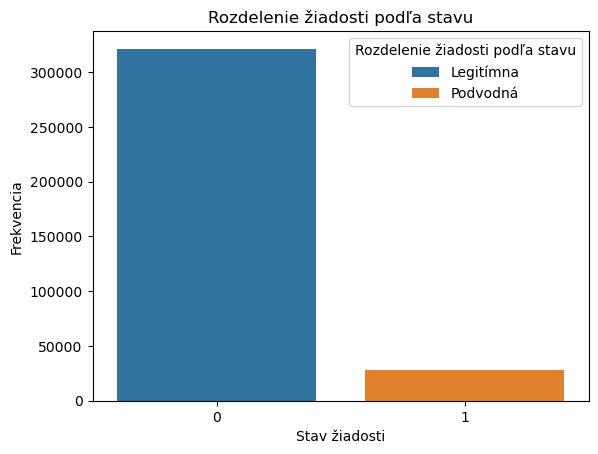

In [68]:
## plot fraud distribuciu
countplot = sns.countplot(x='Fraud',data=dataLoan,hue='Fraud')
plt.ylabel('Frekvencia')
plt.xlabel('Stav žiadosti')
plt.title('Rozdelenie žiadosti podľa stavu')
handles, labels = countplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Legitímna', 'Podvodná'], title='Rozdelenie žiadosti podľa stavu', loc='upper right')
plt.show()

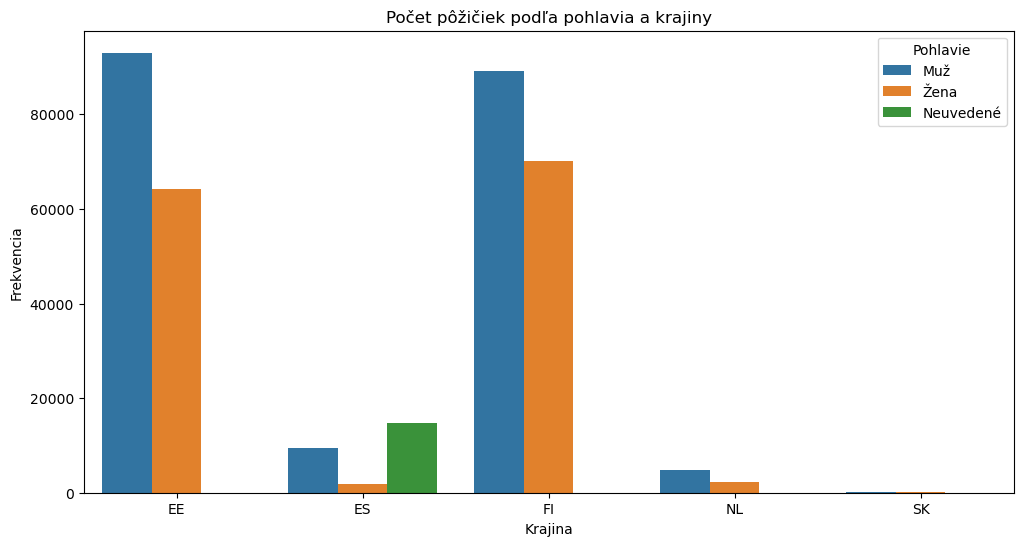

In [69]:
plt.figure(figsize=(12, 6))
count = sns.countplot(x='Country', hue='Gender', data=dataLoan, orient="v")
plt.title('Počet pôžičiek podľa pohlavia a krajiny')
plt.xlabel('Krajina')
plt.ylabel('Frekvencia')
handles, labels = count.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Muž','Žena','Neuvedené'], title='Pohlavie', loc='upper right')
plt.show()

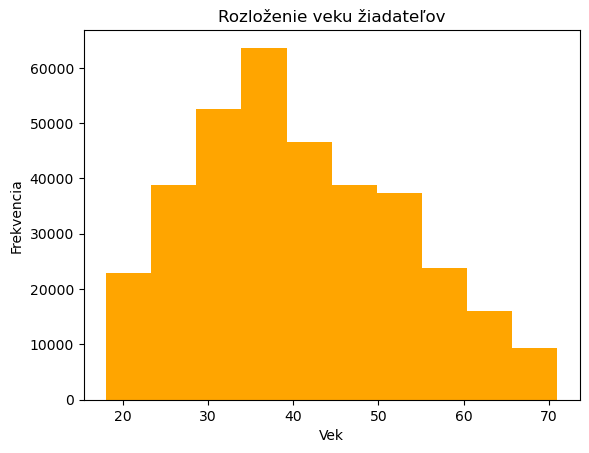

In [70]:
plt.hist(dataLoan['Age'], bins=10, color='orange')
plt.title('Rozloženie veku žiadateľov')
plt.xlabel('Vek')
plt.ylabel('Frekvencia')
plt.show()


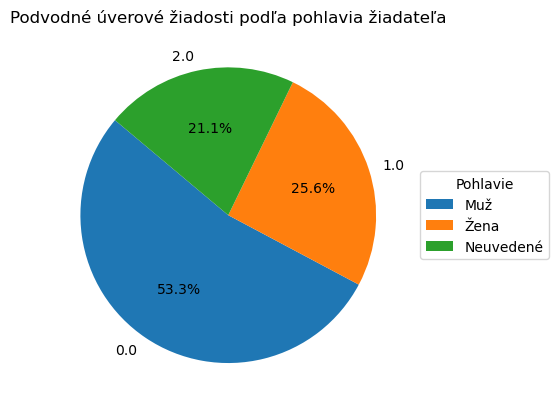

In [71]:
fraud_gender = dataLoan[dataLoan['Fraud'] == 1]['Gender'].value_counts()
plt.pie(fraud_gender, labels=fraud_gender.index, autopct='%1.1f%%', startangle=140)
plt.title('Podvodné úverové žiadosti podľa pohlavia žiadateľa')
plt.legend(labels=['Muž','Žena','Neuvedené'], title="Pohlavie", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()


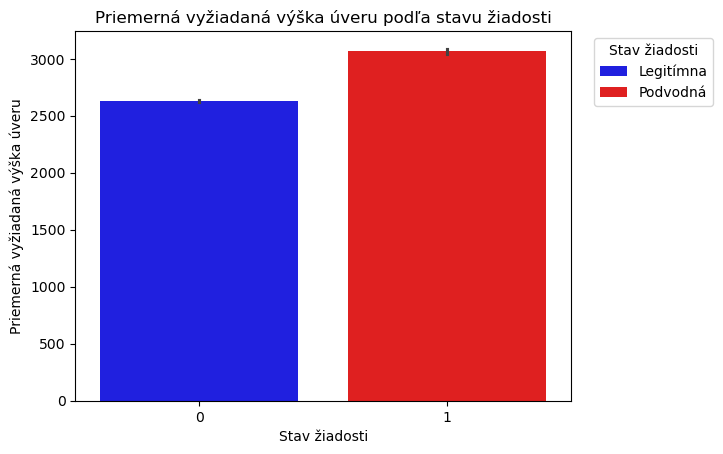

In [72]:

barplot = sns.barplot(x='Fraud', y='AppliedAmount', data=dataLoan, hue='Fraud', palette={0: 'blue', 1: 'red'})

plt.title('Priemerná vyžiadaná výška úveru podľa stavu žiadosti')
plt.xlabel('Stav žiadosti')
plt.ylabel('Priemerná vyžiadaná výška úveru')


handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Legitímna', 'Podvodná'], title='Stav žiadosti', loc='upper right', bbox_to_anchor=(1.3, 1))

plt.show()


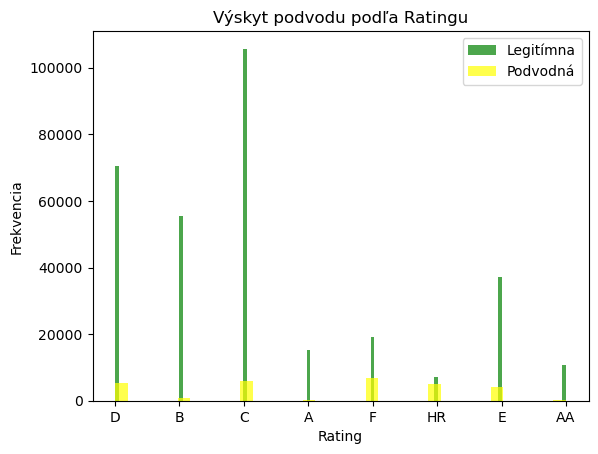

In [73]:

plt.hist(dataLoan[dataLoan['Fraud'] == 0]['Rating'], bins='auto', color='green', alpha=0.7, label='Legitímna')

plt.hist(dataLoan[dataLoan['Fraud'] == 1]['Rating'], bins='auto', color='yellow', alpha=0.7, label='Podvodná')

plt.title('Výskyt podvodu podľa Ratingu')
plt.xlabel('Rating')
plt.ylabel('Frekvencia')
plt.legend()  
plt.show()

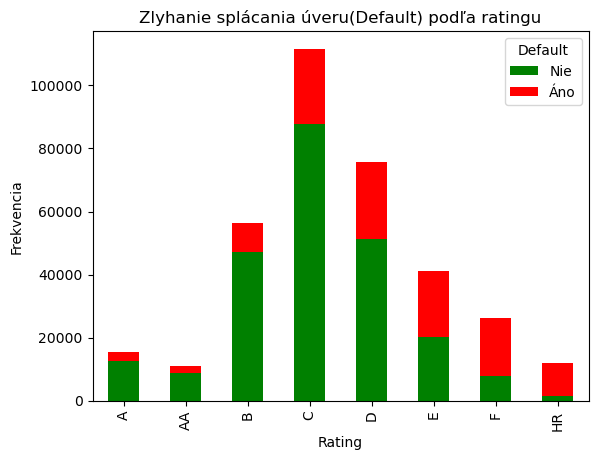

In [74]:
rating_defaults = pd.crosstab(dataLoan['Rating'], dataLoan['Default'])
rating_defaults.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title('Zlyhanie splácania úveru(Default) podľa ratingu')
plt.xlabel('Rating')
plt.ylabel('Frekvencia')
plt.legend(title='Default', labels=['Nie', 'Áno'])
plt.show()


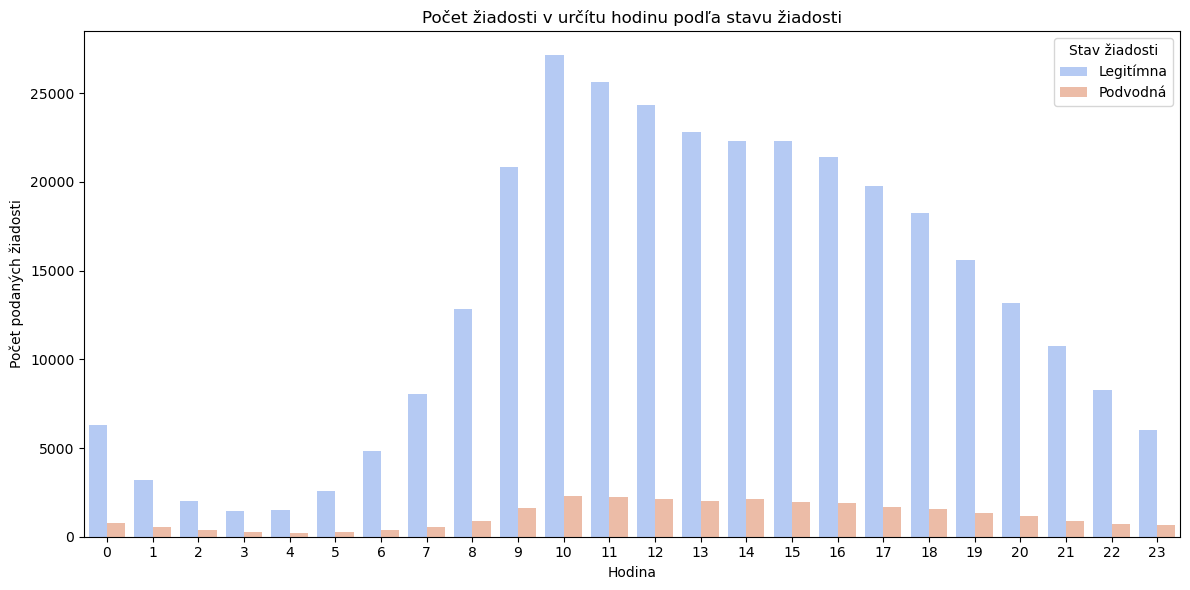

In [75]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ApplicationSignedHour', hue='Fraud', data=dataLoan, palette='coolwarm')
plt.title('Počet žiadosti v určítu hodinu podľa stavu žiadosti')
plt.xlabel('Hodina')
plt.ylabel('Počet podaných žiadosti')
plt.legend(title='Stav žiadosti', labels=['Legitímna', 'Podvodná'])

plt.tight_layout()

plt.show()


In [76]:
summary_hour_fraud = pd.crosstab(index=dataLoan['ApplicationSignedHour'], columns=dataLoan['Fraud'])
pom = (summary_hour_fraud[1] / (summary_hour_fraud[0]) * 100)
pom.apply(lambda x: f"{x:.2f}%")

ApplicationSignedHour
0     12.41%
1     16.83%
2     18.17%
3     17.06%
4     14.26%
5      9.68%
6      7.99%
7      7.01%
8      6.99%
9      7.67%
10     8.48%
11     8.64%
12     8.85%
13     8.74%
14     9.50%
15     8.83%
16     8.88%
17     8.52%
18     8.50%
19     8.47%
20     8.73%
21     8.45%
22     8.68%
23    10.91%
dtype: object

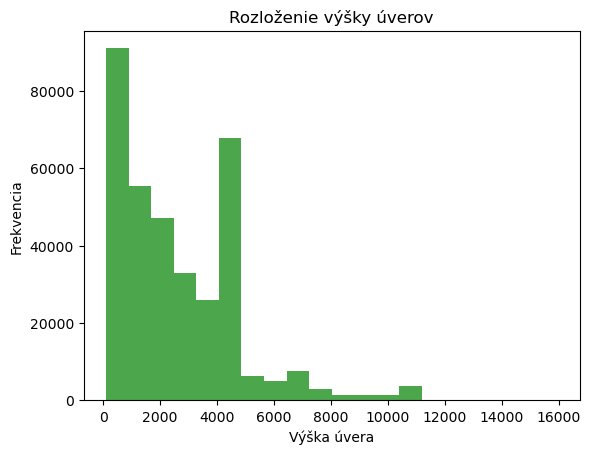

In [77]:
plt.hist(dataLoan['Amount'], bins=20, color='green', alpha=0.7)
plt.title('Rozloženie výšky úverov')
plt.xlabel('Výška úvera')
plt.ylabel('Frekvencia')
plt.show()


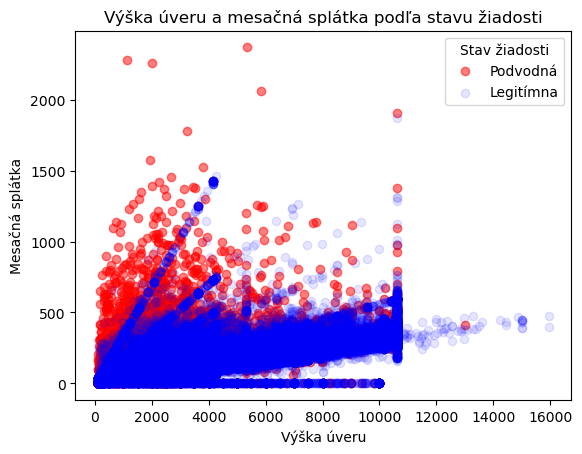

In [78]:
fraud_data = dataLoan[dataLoan['Fraud'] == 1]
no_fraud_data = dataLoan[dataLoan['Fraud'] == 0]
plt.scatter(fraud_data['Amount'], fraud_data['MonthlyPayment'], color='red', alpha=0.5, label='Podvodná')
plt.scatter(no_fraud_data['Amount'], no_fraud_data['MonthlyPayment'], color='blue', alpha=0.1, label='Legitímna')
plt.title('Výška úveru a mesačná splátka podľa stavu žiadosti')
plt.xlabel('Výška úveru')
plt.ylabel('Mesačná splátka')
plt.legend(title="Stav žiadosti")
plt.show()


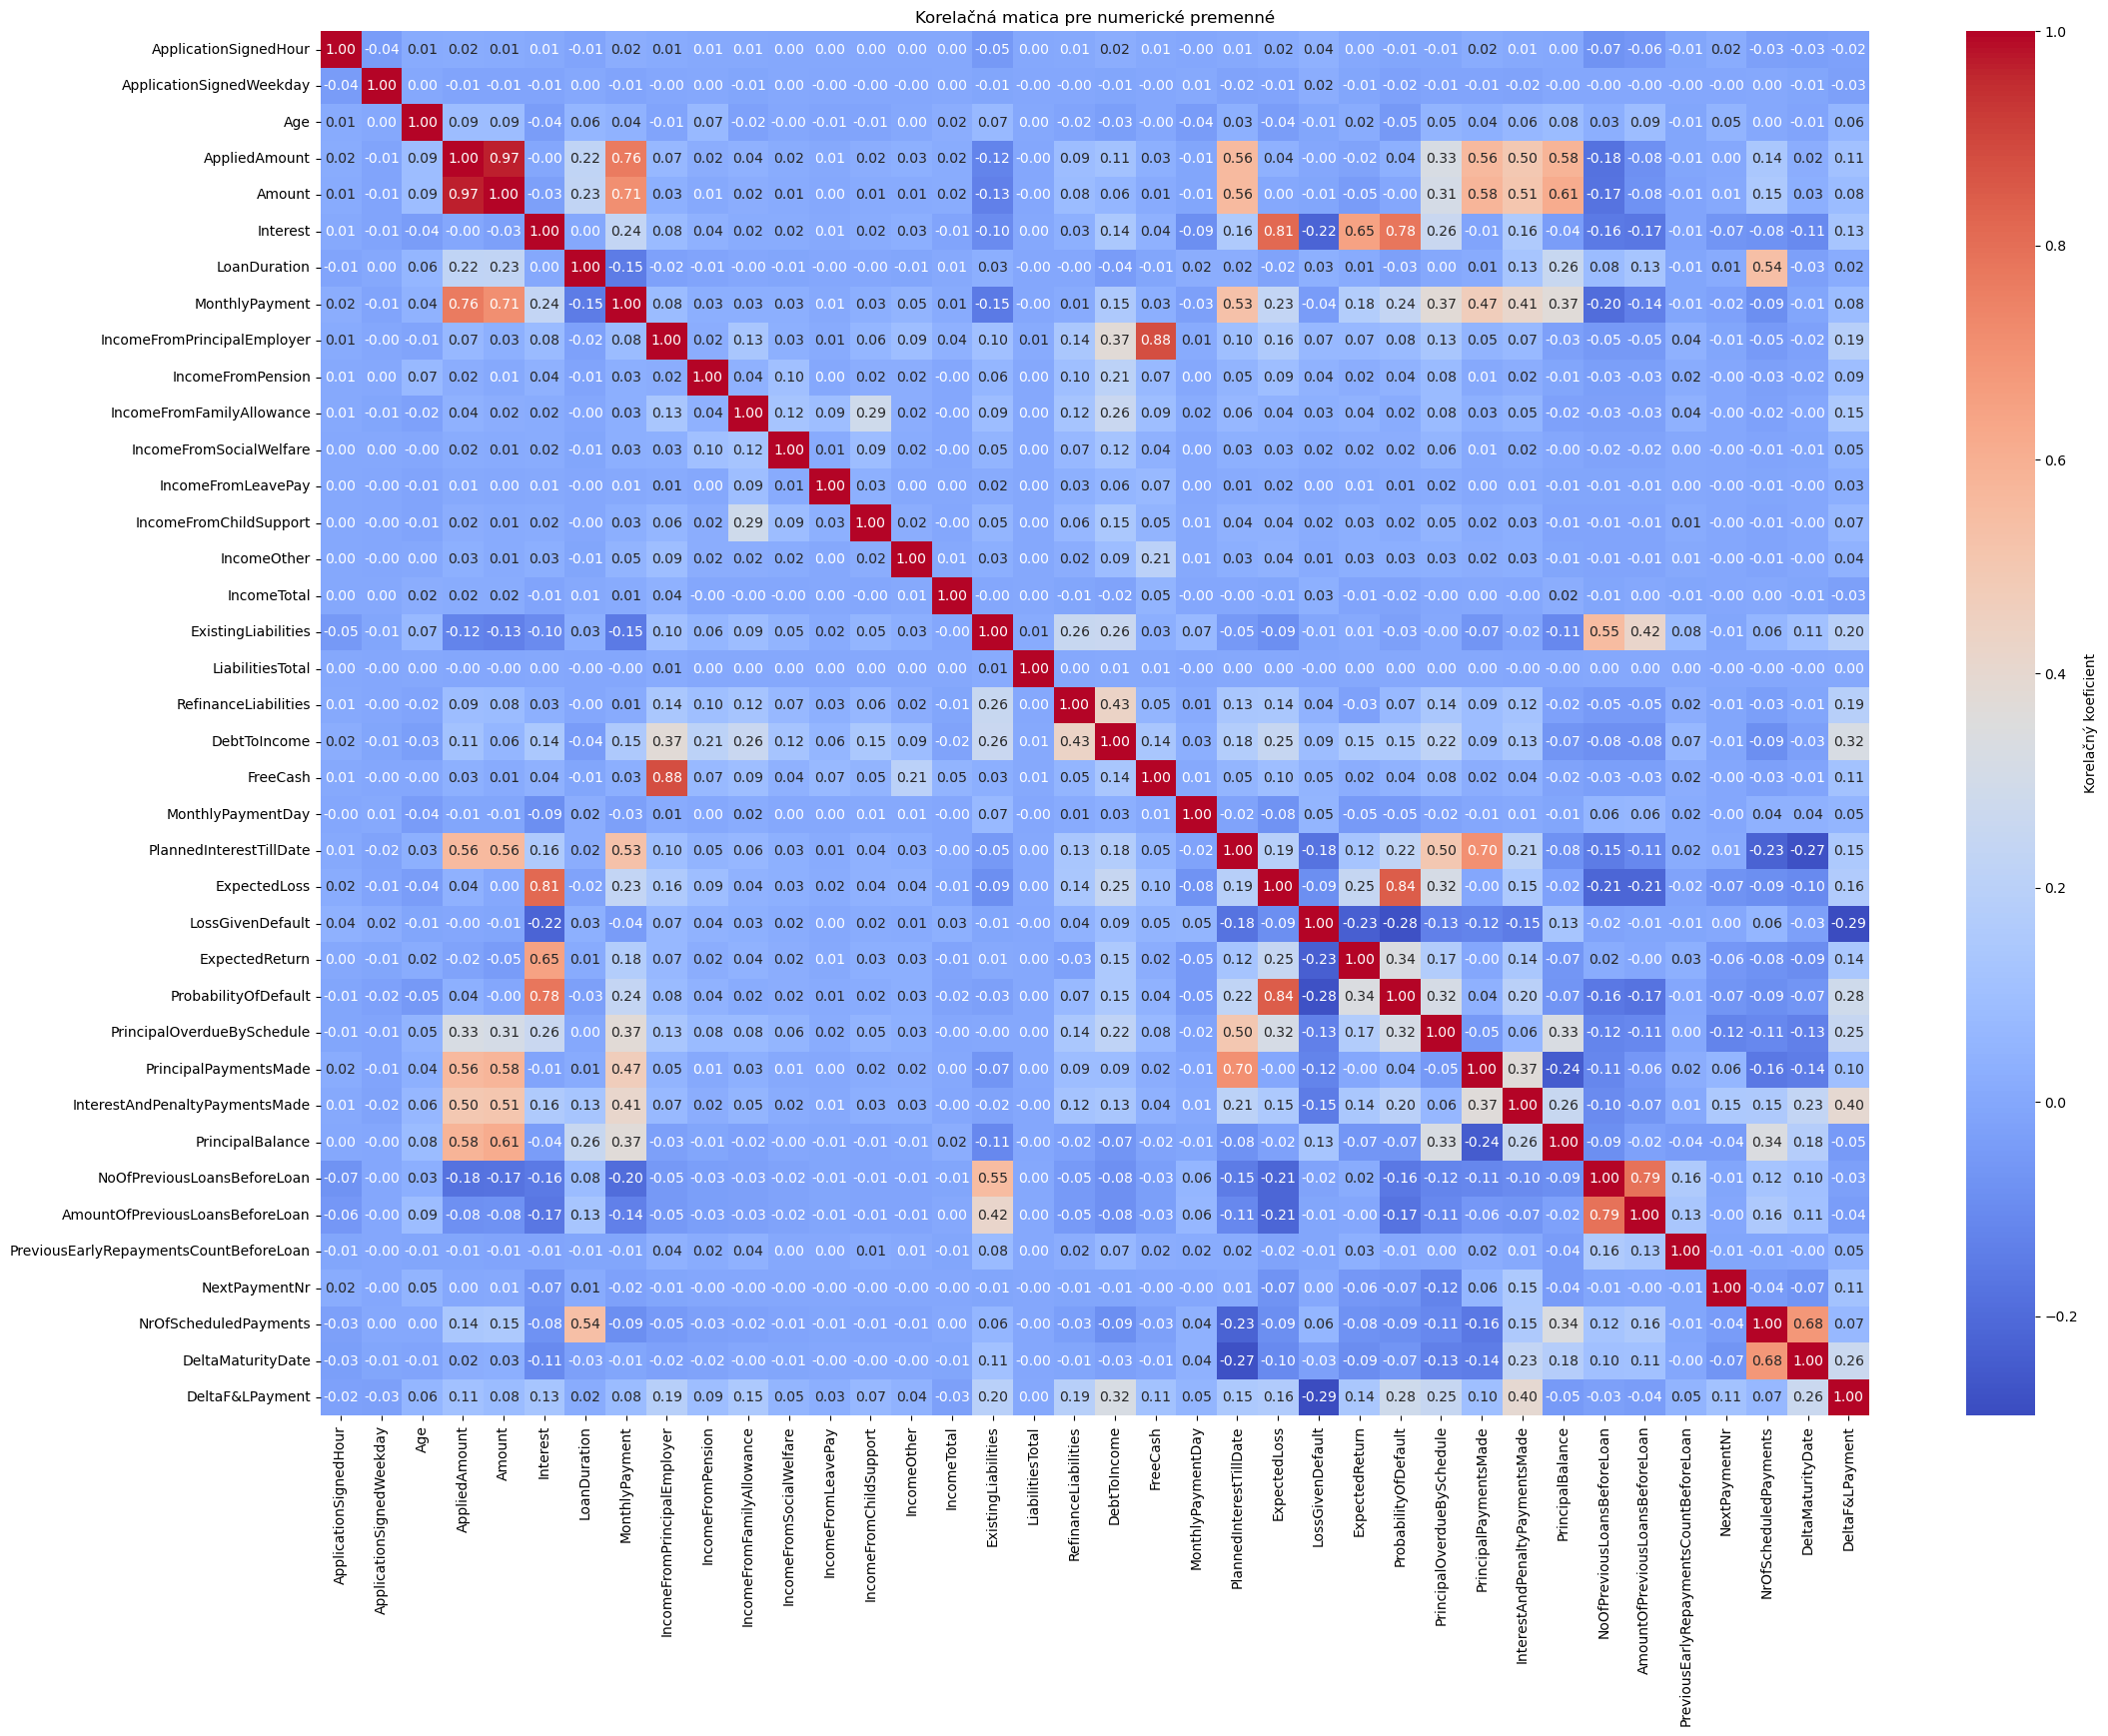

In [79]:
numeric_df = dataLoan.select_dtypes(include=[np.number])
### vypocet korelacnej matice pre numericke hodnoty
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(25, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Korelačný koeficient'})
plt.title('Korelačná matica pre numerické premenné')
plt.savefig("numeric_corr.png", bbox_inches='tight')
plt.show()


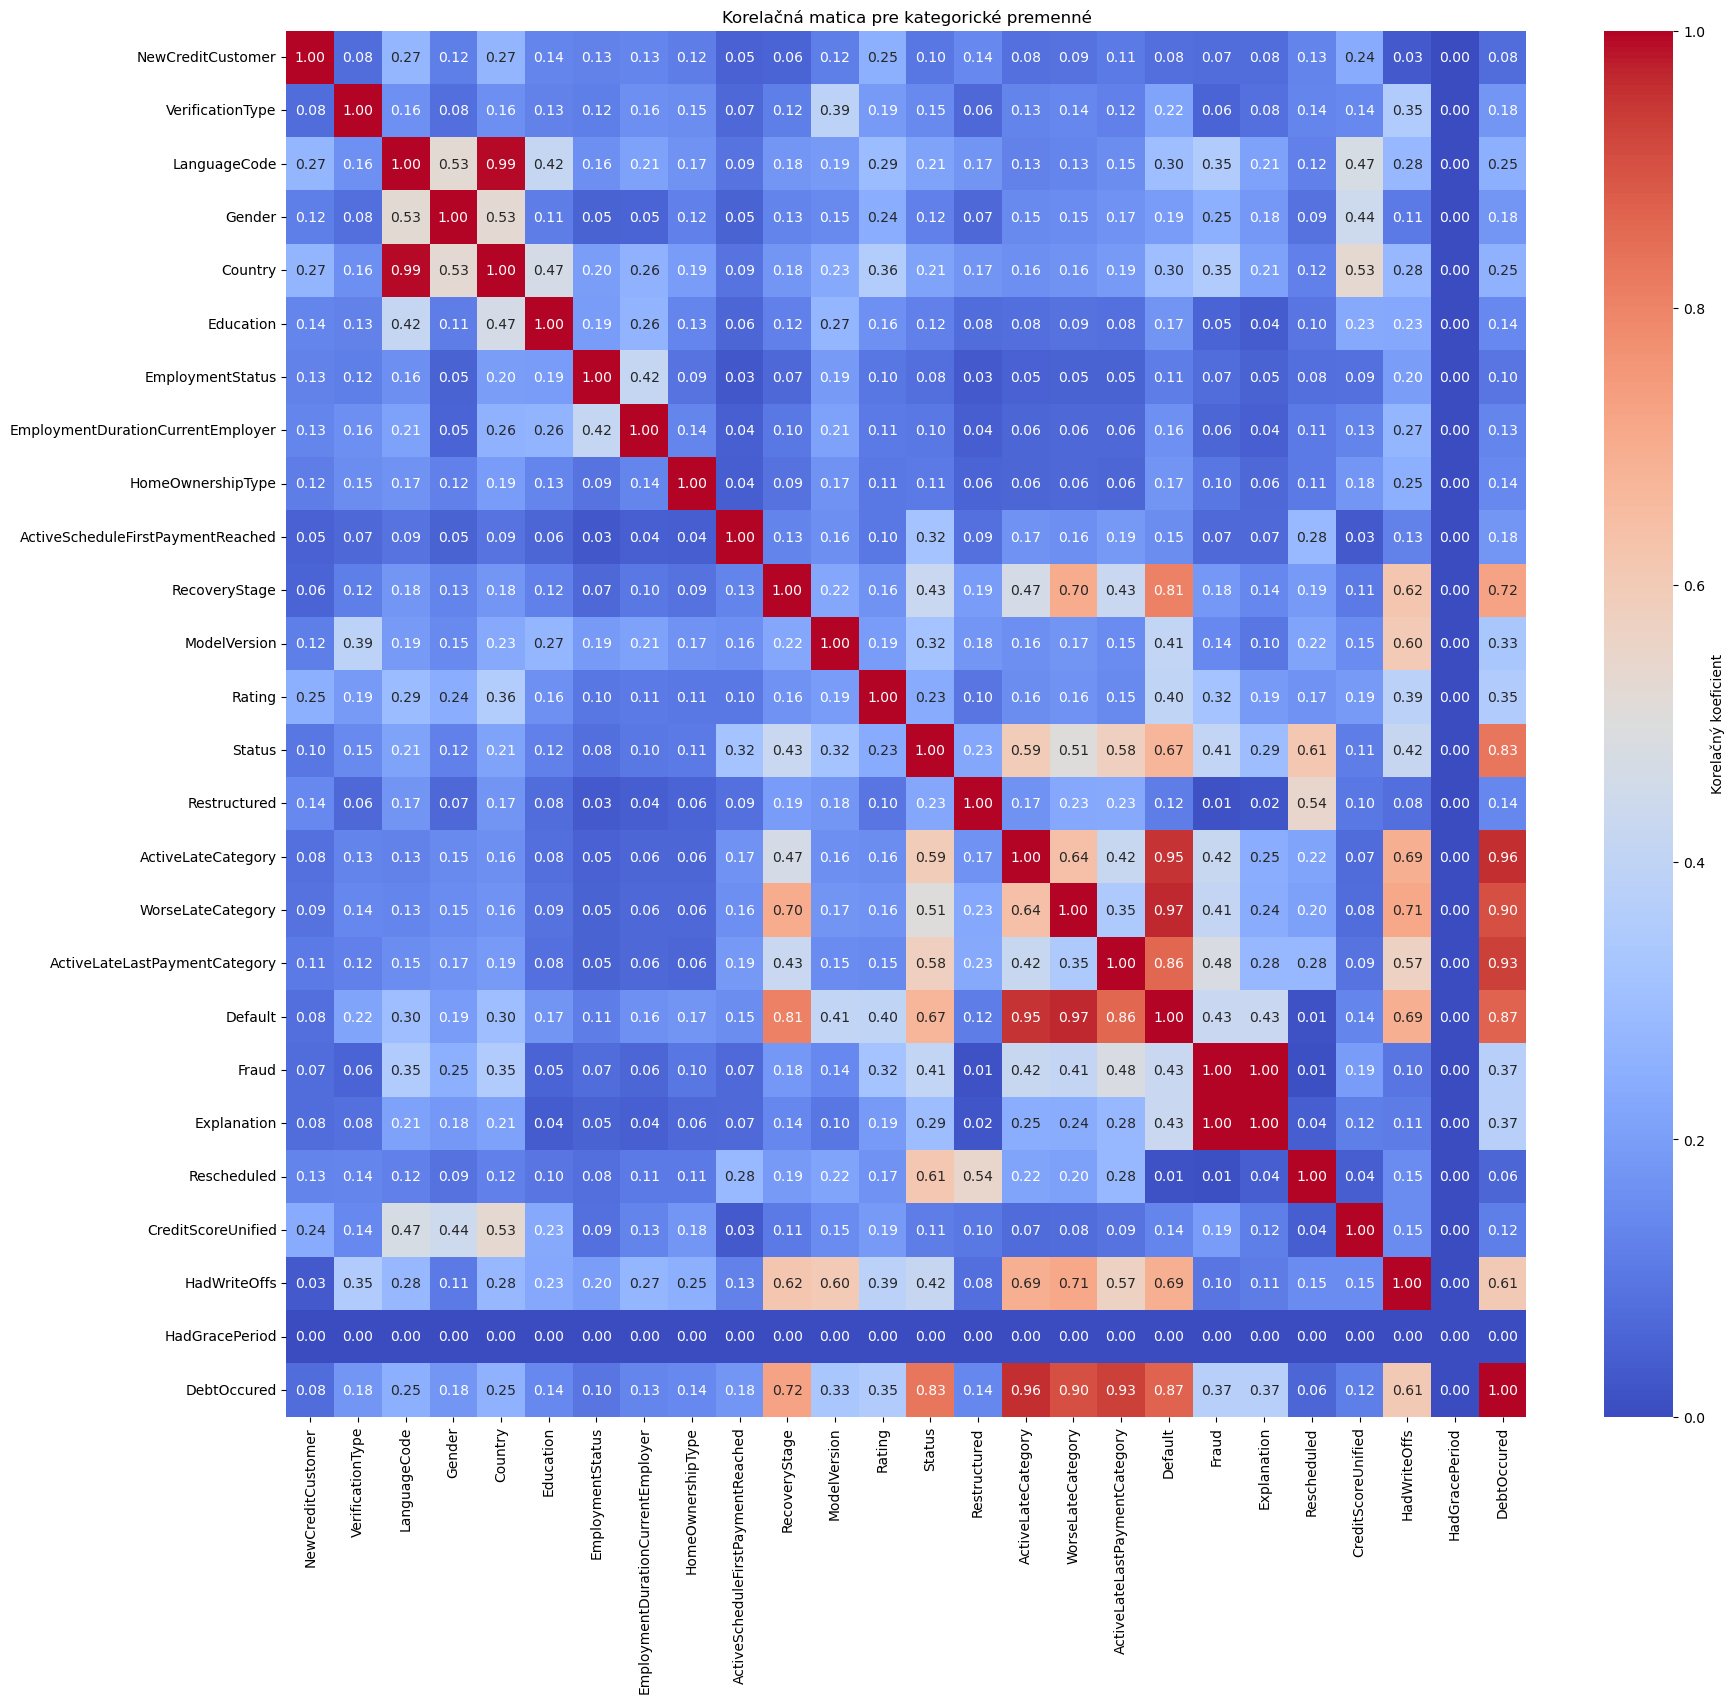

In [80]:
from scipy.stats import chi2_contingency
## korelačná matica pre kategorické premenné
## https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    denominator = min((k_corr-1), (r_corr-1))
    if denominator <= 0:
        return 0
    else:
        return np.sqrt(phi2_corr / denominator)

categorical_df = dataLoan.select_dtypes(include=["category"])

corr_matrix = pd.DataFrame(index=categorical_df.columns, columns=categorical_df.columns)

for col1 in categorical_df.columns:
    for col2 in categorical_df.columns:
        corr_matrix.at[col1, col2] = cramers_v(categorical_df[col1], categorical_df[col2])

corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Korelačný koeficient'})
plt.title('Korelačná matica pre kategorické premenné')
plt.savefig("categorical_corr.png", bbox_inches='tight')
plt.show()



In [81]:
## fraud distribucia ciselne
dataLoan['Fraud'].value_counts()

Fraud
0    321331
1     28482
Name: count, dtype: int64

In [82]:
# poceet Fraud == 1 v datasete
dataLoan.loc[dataLoan.Fraud == 1,:].shape[0]/dataLoan.shape[0] * 100

8.142064474447777

In [83]:
###Rozdelenie na zavislu premmennu a mnozinu nezavislych premennych
y =  dataLoan['Fraud']

X= dataLoan.drop(['Fraud', 'Explanation'], axis=1)


In [84]:

from sklearn.model_selection import train_test_split

In [85]:
## funckia na zmenu cyklickych features
cyclicColumns= []

def add_cyclical_columns(df, cyclicDict):
    for feature, values in cyclic.items():
        max_value = max(values)
        df[f'{feature}_sin'] = np.sin(2 * np.pi * df[feature] / max_value)
        df[f'{feature}_cos'] = np.cos(2 * np.pi * df[feature] / max_value)
        cyclicColumns.append(df[f'{feature}_sin'].name)
        cyclicColumns.append(df[f'{feature}_cos'].name)
        df.drop([feature],inplace=True,axis=1)


In [86]:

cyclic={
    'ApplicationSignedHour':list(range(24)),
    'ApplicationSignedWeekday':list(range(1,8)),
    'MonthlyPaymentDay': list(range(1,32))
}

##tu sa nebojime o to, ze pri transformacii sa jedna o  data leakage, lebo hodiny,dni v tyzdni a pocet dnov v mesiaci je dopredu znamy a nevyskytne
## sa tam neznama hodnota, ako napriklad pri Country, kde moze byt zakaznik z novej krajiny, tu by bol data leakage problematicky, taktiez sa tu nepocita
## priemer a pod z hodnot, ktore by nemal model vediet
add_cyclical_columns(X,cyclic)

In [87]:
##encode zavislu premennu
##mozeme lebo je to binarna uloha a o vsetkych kategoriach sa dopredu vie
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
le = LabelEncoder()
y =le.fit_transform(y)

In [88]:

##kategorie ktore maju jasnu postupnost, nastavim ako zoradene kategorie
orders = {
    'VerificationType':['4.0', '3.0', '2.0', '1.0','0.0'],
    'Education':['5.0', '4.0', '3.0', '2.0', '1.0', '0.0'],
    'EmploymentDurationCurrentEmployer': ['MoreThan5Years','UpTo5Years','UpTo4Years','UpTo3Years','UpTo2Years','UpTo1Year','TrialPeriod', 'Retiree','Other'],
    'Rating': ['AA', 'A', 'B','C','D','E','F','HR'],
    'ActiveLateCategory':['0','1-7','8-15','16-30','31-60','61-90','91-120','121-150','151-180','180+'],
    'WorseLateCategory': ['0','1-7','8-15','16-30','31-60','61-90','91-120','121-150','151-180','180+'],
    'ActiveLateLastPaymentCategory':['0','1-7','8-15','16-30','31-60','61-90','91-120','121-150','151-180','180+'],
    'CreditScoreUnified':[ 'Very Low', 'Low' ,'Average','Not Rated','High','Very High']
}


for column, order in orders.items():
    X[column] = X[column].cat.set_categories(order, ordered=True)
    X[column] = X[column].cat.set_categories(order, ordered=True)


In [89]:
## rozdelenie na test a train mnozinu
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=369,test_size=0.3,stratify=y)

In [90]:
X_train.shape

(244869, 65)

In [91]:
X_test.shape

(104944, 65)

In [92]:
X.select_dtypes(include='category').nunique()

NewCreditCustomer                     2
VerificationType                      4
LanguageCode                          7
Gender                                3
Country                               5
Education                             6
EmploymentStatus                      7
EmploymentDurationCurrentEmployer     9
HomeOwnershipType                    11
ActiveScheduleFirstPaymentReached     2
RecoveryStage                         4
ModelVersion                          8
Rating                                8
Status                                3
Restructured                          2
ActiveLateCategory                   10
WorseLateCategory                    10
ActiveLateLastPaymentCategory        10
Default                               2
Rescheduled                           2
CreditScoreUnified                    6
HadWriteOffs                          2
HadGracePeriod                        1
DebtOccured                           2
dtype: int64

In [93]:
X_train.head() 

,NewCreditCustomer,VerificationType,LanguageCode,Age,Gender,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,Education,EmploymentStatus,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,ActiveScheduleFirstPaymentReached,PlannedInterestTillDate,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,PrincipalOverdueBySchedule,RecoveryStage,ModelVersion,Rating,Status,Restructured,ActiveLateCategory,WorseLateCategory,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,ActiveLateLastPaymentCategory,Default,DeltaMaturityDate,DeltaF&LPayment,Rescheduled,CreditScoreUnified,HadWriteOffs,HadGracePeriod,DebtOccured,ApplicationSignedHour_sin,ApplicationSignedHour_cos,ApplicationSignedWeekday_sin,ApplicationSignedWeekday_cos,MonthlyPaymentDay_sin,MonthlyPaymentDay_cos
291078,True,4.0,4,65,1.0,FI,3835.0,3835.0,19.83,36,141.10,5.0,3.0,MoreThan5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3400.0,0,0.00,0,0.0,0.0,True,0.00,0.107322,0.752196,0.038086,0.142679,0.00,1.0,0.0,D,Current,True,0,1-7,763.38,617.4905,3071.62,0.0,0.0,0.0,4.0,57.0,0,0,915.0,335.0,True,Low,False,True,False,-0.519584,0.854419,4.338837e-01,-0.900969,-0.485302,-0.874347
162296,True,4.0,1,23,1.0,EE,6911.0,6911.0,22.34,60,207.44,3.0,3.0,UpTo5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0,0.00,0,0.0,0.0,True,3675.42,0.058532,0.454440,0.104176,0.128800,2227.99,0.0,6.0,C,Late,False,180+,180+,1447.43,1546.7400,5463.57,0.0,0.0,0.0,0.0,60.0,180+,1,0.0,672.0,False,Very Low,True,True,True,-0.942261,-0.334880,-9.749279e-01,-0.222521,0.201299,0.979530
136380,True,4.0,1,34,0.0,EE,637.0,637.0,22.13,30,29.34,3.0,0.0,Other,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0,0.00,0,0.0,0.0,True,419.64,0.060713,0.000000,0.109441,0.108703,0.00,1.0,6.0,C,Repaid,True,0,16-30,637.00,224.6800,0.00,0.0,0.0,0.0,5.0,30.0,0,0,1358.0,839.0,False,Very Low,False,True,False,-0.631088,-0.775711,-2.449294e-16,1.000000,0.724793,0.688967
331035,True,4.0,4,53,1.0,FI,4146.0,4146.0,18.52,60,105.40,3.0,3.0,UpTo5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,1,150.00,0,0.0,0.0,True,152.52,0.067904,0.756105,0.074045,0.089807,0.00,0.0,0.0,C,Current,False,0,0,1425.87,267.0070,2720.13,0.0,0.0,0.0,2.0,55.0,0,0,0.0,152.0,True,Average,False,True,False,-0.136167,-0.990686,-2.449294e-16,1.000000,0.571268,0.820763
341991,True,4.0,4,29,1.0,FI,3835.0,3835.0,18.54,60,97.49,5.0,0.0,Other,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,2,177.28,0,0.0,0.0,True,315.89,0.066143,0.756105,0.071663,0.087478,0.00,0.0,0.0,C,Current,False,0,0,355.69,192.6885,3479.31,1.0,4146.0,0.0,4.0,59.0,0,0,0.0,91.0,True,Average,False,True,False,-0.816970,-0.576680,4.338837e-01,-0.900969,-0.790776,-0.612106


In [94]:
### roztriedenie kategorickych premennych 

from sklearn.compose import ColumnTransformer
from category_encoders import BaseNEncoder
from sklearn.preprocessing import PowerTransformer

ordinal_columns = list(orders.keys())
nominal_columns = [column for column in X_train.columns if X_train[column].dtype == 'category' and  X_train[column].name not in orders.keys()]
numeric_columns = [column for column in X_train.select_dtypes(include=['int', 'float']).columns.tolist() if column not in cyclicColumns]




In [95]:
X_train.head()

,NewCreditCustomer,VerificationType,LanguageCode,Age,Gender,Country,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,Education,EmploymentStatus,EmploymentDurationCurrentEmployer,HomeOwnershipType,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,ActiveScheduleFirstPaymentReached,PlannedInterestTillDate,ExpectedLoss,LossGivenDefault,ExpectedReturn,ProbabilityOfDefault,PrincipalOverdueBySchedule,RecoveryStage,ModelVersion,Rating,Status,Restructured,ActiveLateCategory,WorseLateCategory,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,NextPaymentNr,NrOfScheduledPayments,ActiveLateLastPaymentCategory,Default,DeltaMaturityDate,DeltaF&LPayment,Rescheduled,CreditScoreUnified,HadWriteOffs,HadGracePeriod,DebtOccured,ApplicationSignedHour_sin,ApplicationSignedHour_cos,ApplicationSignedWeekday_sin,ApplicationSignedWeekday_cos,MonthlyPaymentDay_sin,MonthlyPaymentDay_cos
291078,True,4.0,4,65,1.0,FI,3835.0,3835.0,19.83,36,141.10,5.0,3.0,MoreThan5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3400.0,0,0.00,0,0.0,0.0,True,0.00,0.107322,0.752196,0.038086,0.142679,0.00,1.0,0.0,D,Current,True,0,1-7,763.38,617.4905,3071.62,0.0,0.0,0.0,4.0,57.0,0,0,915.0,335.0,True,Low,False,True,False,-0.519584,0.854419,4.338837e-01,-0.900969,-0.485302,-0.874347
162296,True,4.0,1,23,1.0,EE,6911.0,6911.0,22.34,60,207.44,3.0,3.0,UpTo5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000.0,0,0.00,0,0.0,0.0,True,3675.42,0.058532,0.454440,0.104176,0.128800,2227.99,0.0,6.0,C,Late,False,180+,180+,1447.43,1546.7400,5463.57,0.0,0.0,0.0,0.0,60.0,180+,1,0.0,672.0,False,Very Low,True,True,True,-0.942261,-0.334880,-9.749279e-01,-0.222521,0.201299,0.979530
136380,True,4.0,1,34,0.0,EE,637.0,637.0,22.13,30,29.34,3.0,0.0,Other,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0,0.00,0,0.0,0.0,True,419.64,0.060713,0.000000,0.109441,0.108703,0.00,1.0,6.0,C,Repaid,True,0,16-30,637.00,224.6800,0.00,0.0,0.0,0.0,5.0,30.0,0,0,1358.0,839.0,False,Very Low,False,True,False,-0.631088,-0.775711,-2.449294e-16,1.000000,0.724793,0.688967
331035,True,4.0,4,53,1.0,FI,4146.0,4146.0,18.52,60,105.40,3.0,3.0,UpTo5Years,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,1,150.00,0,0.0,0.0,True,152.52,0.067904,0.756105,0.074045,0.089807,0.00,0.0,0.0,C,Current,False,0,0,1425.87,267.0070,2720.13,0.0,0.0,0.0,2.0,55.0,0,0,0.0,152.0,True,Average,False,True,False,-0.136167,-0.990686,-2.449294e-16,1.000000,0.571268,0.820763
341991,True,4.0,4,29,1.0,FI,3835.0,3835.0,18.54,60,97.49,5.0,0.0,Other,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,2,177.28,0,0.0,0.0,True,315.89,0.066143,0.756105,0.071663,0.087478,0.00,0.0,0.0,C,Current,False,0,0,355.69,192.6885,3479.31,1.0,4146.0,0.0,4.0,59.0,0,0,0.0,91.0,True,Average,False,True,False,-0.816970,-0.576680,4.338837e-01,-0.900969,-0.790776,-0.612106


In [96]:
#244869 riadkov a 73 
X_train.shape

(244869, 65)

In [97]:

#dataset celkovo obsahuje
print(f"{X_train.shape[0] + X_test.shape[0]} zaznamov")
print(f"{X_train.shape[1] +1} premennych")

349813 zaznamov
66 premennych


In [98]:
##pocet Fraud 0/1
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([224932,  19937], dtype=int64))

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


################ pipeline pre grid a randomized search

# transformer =  ColumnTransformer(transformers=[
#    ('ordinal',OrdinalEncoder(),ordinal_columns),
#     ('nominal',BaseNEncoder(base=3, cols=nominal_columns,handle_unknown='value'),nominal_columns),
#     ('numeric',PowerTransformer(),numeric_columns)

    
# ],remainder='passthrough')


# models = [
#     ('Logistic_Regression',LogisticRegression()),
#     ('Decision_Tree',DecisionTreeClassifier()),
#     ('Random_Forrest',RandomForestClassifier())
# ]

# pipes = {modelName: Pipeline([('transformer',transformer),('model',model)]) for modelName,model in models}

In [100]:
# ################# dict pre hyperparametre pre randomizedsearch
# param_LogReg = [
#     {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['newton-cholesky'], 
#     'model__penalty': ['l2', None],
#     'model__max_iter': [200, 300, 400, 500], 
#     'model__class_weight': [None, 'balanced'] },
#     {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['saga'], 
#     'model__penalty': [ 'l1', 'l2', None],
#     'model__max_iter': [200, 300, 400, 500], 
#     'model__class_weight': [None, 'balanced'] },
# {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['sag'], 
#     'model__penalty': ['l2', None],
#     'model__max_iter': [2000, 2100, 2200, 2300], 
#     'model__class_weight': [None, 'balanced'] },
# {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['lbfgs'], 
#     'model__penalty': ['l2', None],
#     'model__max_iter': [2000, 2100, 2200, 2300], 
#     'model__class_weight': [None, 'balanced'] },
# {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['newton-cg'], 
#     'model__penalty': ['l2', None],
#     'model__max_iter': [200, 300, 400, 500], 
#     'model__class_weight': [None, 'balanced'] },
#     {'model__C': np.logspace(-3, 9, 30),
#     'model__solver': ['saga'], 
#     'model__penalty': ['elasticnet'],
#     'model__l1_ratio': np.arange(0.0, 1.0, 0.2),
#     'model__max_iter': [2000, 2100, 2200, 2300], 
#     'model__class_weight': [None, 'balanced'] },
# ]

# param_DTree= {
#     'model__criterion': ['gini', 'entropy'],
#     'model__splitter': ['best', 'random'],
#     'model__max_depth': [None,10, 20, 30, 40, 50],
#     'model__min_samples_split': [3, 7, 10, 20],
#     'model__min_samples_leaf': [2, 4, 6, 10],
#     'model__min_impurity_decrease': [0.0, 0.01, 0.1]
# }
# param_RF = {
#     'model__n_estimators': [20, 50, 75, 100, 125, 150], 
#     'model__max_depth': [None,10, 20, 30, 40, 50, 60, 70], 
#     'model__min_samples_split': [2, 5, 10, 15, 20],
#     'model__min_samples_leaf': [1, 2, 4, 6, 8],
#     'model__min_weight_fraction_leaf': [0.0, 0.01, 0.02],  
#     'model__min_impurity_decrease': [0.0, 0.01, 0.02, 0.1]  
# }

# randomDict ={
#     'Logistic_Regression':param_LogReg,
#     'Decision_Tree':param_DTree,
#     'Random_Forrest':param_RF
# }

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import recall_score

# #########     Randomized Search ###################### TRVA VELMI DLHO !!!!!!!!!! ######


# results = {}

# betaLR=0

# for modelName, pipe in pipes.items():
#     grid_search = RandomizedSearchCV(pipe, randomDict[modelName], cv=5,n_iter=25, scoring=make_scorer(fbeta_score, beta=2),verbose=3,random_state=369,n_jobs=-1,error_score='raise')
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_test)
#     fbeta = fbeta_score(y_test, y_pred, beta=2)
#     results[modelName] = {'Best Parameters': grid_search.best_params_}
#     betaLR=fbeta
#     print(f"{modelName} - Best Parameters: {grid_search.best_params_}, FBeta: {fbeta}")

# #########
# #Fitting 5 folds for each of 25 candidates, totalling 125 fits
# #Logistic_Regression - Best Parameters: {'model__solver': 'newton-cholesky', 'model__penalty': 'l2', 'model__max_iter': 300, 'model__class_weight': None, 'model__C': 10826.36733874054}, FBeta: 0.9130301312930953
# #Fitting 5 folds for each of 25 candidates, totalling 125 fits
# #Decision_Tree - Best Parameters: {'model__splitter': 'best', 'model__min_samples_split': 3, 'model__min_samples_leaf': 10, 'model__min_impurity_decrease': 0.0, 'model__max_depth': 40, 'model__criterion': 'entropy'}, FBeta: 0.9538739754338992
# #Fitting 5 folds for each of 25 candidates, totalling 125 fits
# #Random_Forrest - Best Parameters: {'model__n_estimators': 125, 'model__min_weight_fraction_leaf': 0.0, 'model__min_samples_split': 15, 'model__min_samples_leaf': 1, 'model__min_impurity_decrease': 0.0, 'model__max_depth': 50}, FBeta: 0.908950213100312###########
# #####    

In [102]:
# ########### vytvorenie dict hyperparametorv pre GridSearch podla RandomizdSearch

# pom = results["Logistic_Regression"]['Best Parameters']


# param_LogReg_Grid = [
#     {'model__C': np.linspace(pom['model__C'] 
#                              * 0.1, pom['model__C'] * 10, 2),
#     'model__solver': [pom['model__solver']], 
#     'model__penalty':[pom['model__penalty']],
#     'model__max_iter': [pom['model__max_iter']-25,pom['model__max_iter'],
#                        pom['model__max_iter']+25],
#     'model__class_weight':[pom['model__class_weight']],
#     'model__l1_ratio': [pom['model__l1_ratio'] if 'model__l1_ratio' in pom else None],
#     },
 
#  ]
# pom = results["Decision_Tree"]['Best Parameters']

# param_DTree_Grid= {
#     'model__criterion': [pom['model__criterion']],
#     'model__splitter': [pom['model__splitter']],
#     'model__max_depth': [pom['model__max_depth']],
#     'model__min_samples_split':  [pom['model__min_samples_split'], pom['model__min_samples_split']+2],
#     'model__min_samples_leaf':[ pom['model__min_samples_leaf'], pom['model__min_samples_leaf']+1],
#     'model__min_impurity_decrease': [pom['model__min_impurity_decrease']]
# }
# pom = results["Random_Forrest"]['Best Parameters']
# param_RF_Grid = {
#     'model__n_estimators': [pom['model__n_estimators'], pom['model__n_estimators'] + 50],
#     'model__max_depth':  [pom['model__max_depth']],
#     'model__min_samples_leaf': [pom['model__min_samples_leaf'], pom['model__min_samples_leaf']+1],
#     'model__min_samples_split':  [pom['model__min_samples_split'], pom['model__min_samples_split']+1],
#     'model__min_weight_fraction_leaf': [pom['model__min_weight_fraction_leaf']],
#     'model__min_impurity_decrease': [pom['model__min_impurity_decrease']]
# }
# gridDict ={
#     'Logistic_Regression':param_LogReg_Grid,
#     'Decision_Tree':param_DTree_Grid,
#     'Random_Forrest':param_RF_Grid
# }


In [103]:
# #########     GRID Search ###################### TRVA DLHO !!!!!!!!!! ######


# results = {}

# for modelName, pipe in pipes.items():
#     grid_search = GridSearchCV(pipe, gridDict[modelName], cv=5, scoring=make_scorer(fbeta_score, beta=2),verbose=3,n_jobs=-1)
#     grid_search.fit(X_train, y_train)
#     best_model = grid_search.best_estimator_
#     y_pred = best_model.predict(X_test)
#     fbeta = fbeta_score(y_test, y_pred, beta=2)
#     recall = recall_score(y_test, y_pred)
#     results[modelName] = {'Best Parameters': grid_search.best_params_}
#     print(f"{modelName} - Best Parameters: {grid_search.best_params_}, FBeta: {fbeta}, Recall:{recall}")

# #########
# #Fitting 5 folds for each of 6 candidates, totalling 30 fits
# #Logistic_Regression - Best Parameters: {'model__C': 108263.6733874054, 'model__class_weight': None, 'model__l1_ratio': None, 'model__max_iter': 275, 'model__penalty': 'l2', 'model__solver': 'newton-cholesky'}, FBeta: 0.9130301312930953, Recall:0.9049736688121709
# #Fitting 5 folds for each of 4 candidates, totalling 20 fits
# #Decision_Tree - Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 40, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 11, 'model__min_samples_split': 3, 'model__splitter': 'best'}, FBeta: 0.9537341474870831, Recall:0.9504973668812171
# #Fitting 5 folds for each of 8 candidates, totalling 40 fits
# #Random_Forrest - Best Parameters: {'model__max_depth': 50, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 1, 'model__min_samples_split': 15, 'model__min_weight_fraction_leaf': 0.0, 'model__n_estimators': 175}, FBeta: 0.9086904761904759, Recall:0.8932709186658865

# #########

In [104]:
### pipeline zlozena s modelov a transformmacii ### Modely su nastavene podla zakomentovanych grid search a randomized search hladani

models = [
    ('Logistic_Regression',LogisticRegression(
        C=108263.6733874054, class_weight=None, l1_ratio=None, max_iter=275, penalty='l2', solver='newton-cholesky'
    )),
    ('Decision_Tree',DecisionTreeClassifier(
        criterion='entropy', max_depth=40, min_impurity_decrease= 0.0, min_samples_leaf=11, min_samples_split=3, splitter='best')),
    ('Random_Forrest',RandomForestClassifier(
        max_depth= 50, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=15, min_weight_fraction_leaf=0.0, n_estimators=175))
]
transformer =  ColumnTransformer(transformers=[
   ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),ordinal_columns),
    ('nominal',BaseNEncoder(base=3, cols=nominal_columns,handle_unknown='value'),nominal_columns),
    ('numeric',PowerTransformer(),numeric_columns)

    
],remainder='passthrough')



pipes = {modelName: Pipeline([('transformer',transformer),('model',model)]) for modelName,model in models}

Vysledky pre Logistic_Regression :


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.2min remaining:   31.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.2min remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


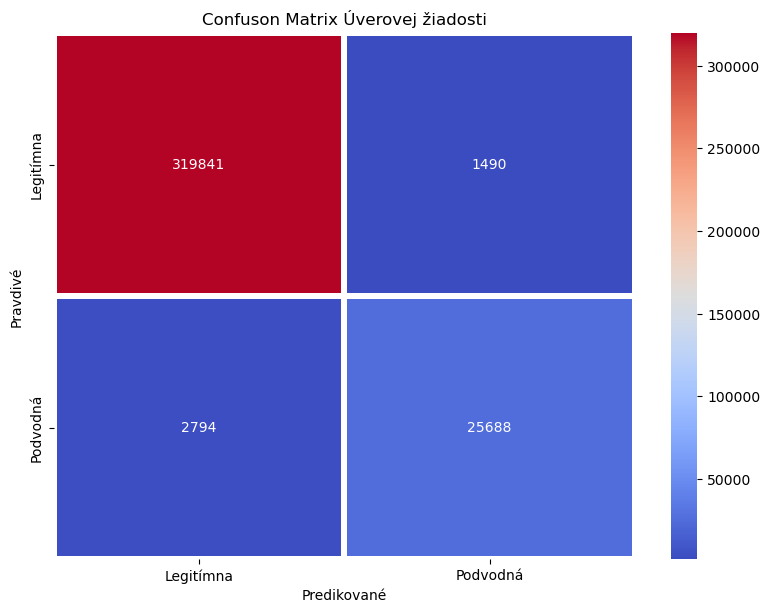



------------------------------------------------------------------------------------


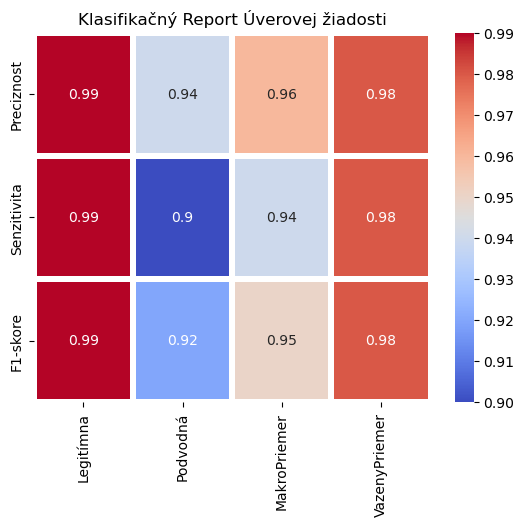



------------------------------------------------------------------------------------
Vysledky pre Decision_Tree :


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


KeyboardInterrupt: 

In [105]:
###################### Trocha trva  ###########
##stratisfikovana 10-fold cross validation predikcia s vypisanymi confusion matrix a classification report
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import cross_validate
import math
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
y_pred= {}
estimators={}
reports={}
feature_names={}
for modelName, pipe in pipes.items():
    print(f"Vysledky pre {modelName} :")
    y_pred[modelName] = cross_val_predict(pipe,X,y,cv=StratifiedKFold(n_splits=10, random_state=369,shuffle=True),n_jobs=-1,verbose=3,method='predict')
    estimators[modelName]=cross_validate(pipe, X, y, cv=StratifiedKFold(n_splits=10, random_state=369,shuffle=True), return_estimator=True, n_jobs=-1,verbose=3)
    pipe.fit(X, y)
    feature_names[modelName] = pipe['transformer'].get_feature_names_out()

    
    ## confusion matrix
    cm = confusion_matrix(y, y_pred[modelName])
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='g',cmap='coolwarm',linewidth=3,
                xticklabels=['Legitímna', 'Podvodná'],
                yticklabels=['Legitímna', 'Podvodná'])
    for text in ax.texts:
        text.set_ha("bottom")
        text.set_va("bottom")
    plt.xlabel('Predikované')
    plt.ylabel('Pravdivé')
    plt.tight_layout()
    plt.title('Confuson Matrix Úverovej žiadosti')
    plt.show()
    print("\n\n------------------------------------------------------------------------------------")
    ## reports
    reports[modelName] = classification_report(y, y_pred[modelName], target_names=['Legitímna', 'Podvodná'], output_dict=True)
    ##zaokruhelnie vysledkov dole
    def floor_nested_dict(d):
        for key, value in list(d.items()):   
            if isinstance(value, dict):  
                floor_nested_dict(value)  
            else:
                d[key] = math.floor(value * 100) / 100 

    floor_nested_dict(reports[modelName])

    report_df = pd.DataFrame(reports[modelName]).transpose()
    report_df.rename(index={'macro avg': 'MakroPriemer', 'weighted avg': 'VazenyPriemer','recall':'Senzitivita','precision':'Preciznost'}
                     ,columns={'precision':'Preciznost','recall':'Senzitivita','f1-score':'F1-skore'}, inplace=True)
    sns.heatmap(report_df.transpose().loc[:, ['Legitímna', 'Podvodná','MakroPriemer','VazenyPriemer']][:-1], annot=True, cmap='coolwarm',linewidths=3)
    plt.title('Klasifikačný Report Úverovej žiadosti')
    plt.show()
    print("\n\n------------------------------------------------------------------------------------")
                            
    

In [ ]:
#### vypis ROC s AUC
for modelName, y_pred_ in y_pred.items():
    print(modelName)
    fpr, tpr, thresholds = roc_curve(y, y_pred_)
    
    auc_score = roc_auc_score(y,y_pred_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC (Plocha pod krivkou = {math.floor(auc_score*100)/100})")
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
    plt.xlim([0.0, 1.005])
    plt.ylim([0.0, 1.005])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    print("\n\n------------------------------------------------------------------------------------")
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
for modelName, pred in y_pred.items():
     print(f"{modelName} Presnost: {math.floor(accuracy_score(y, pred)*100)/100}.\n")



In [ ]:
for modelName, pred in y_pred.items():
    cm = confusion_matrix(y, y_pred[modelName])
    specificity = (cm[0][0])/(cm[0][0] + cm[1][0])
    print(f"{modelName} Specifita: {math.floor(specificity*100)/100}.\n")

In [ ]:
from sklearn.metrics import balanced_accuracy_score
for modelName, pred in y_pred.items():
    cm = confusion_matrix(y, y_pred[modelName])
    print(f"{modelName} Vyvazena presnost: {math.floor(balanced_accuracy_score(y, pred)*100)/100}.\n")





In [ ]:
##fbeta_score , beta = 2
from sklearn.metrics import fbeta_score
for modelName, pred in y_pred.items():
    cm = confusion_matrix(y, y_pred[modelName])
    print(f"{modelName} Beta F1 skore: {math.floor(fbeta_score(y, pred,beta=2)*100)/100}.\n")


In [ ]:
from sklearn.metrics import matthews_corrcoef
for modelName, pred in y_pred.items():
    cm = confusion_matrix(y, y_pred[modelName])
    print(f"{modelName} MCC: {math.floor(matthews_corrcoef(y, pred)*100)/100}.\n")

In [ ]:
### pocet stlpcov/premennych po transformaciach

len(feature_names["Logistic_Regression"])

In [ ]:
## LOGISTICKA REGRESIA

In [ ]:
### koeficienty log reg s najvacsiou vahou v zozname, od vahy aspon vyssie ako 0.8 aby ich bolo menej 
feature_importances_LR = np.zeros((len(estimators["Logistic_Regression"]["estimator"]), estimators["Logistic_Regression"]["estimator"][0].named_steps['model'].coef_.shape[1]))
for i, estimator in enumerate(estimators["Logistic_Regression"]["estimator"]):
    feature_importances_LR[i, :] = estimator.named_steps['model'].coef_[0]
average_feature_importances_LR = np.mean(feature_importances_LR, axis=0)

importances_LR = pd.DataFrame(data={
    'Attribute': feature_names["Logistic_Regression"],
    'Importance': average_feature_importances_LR
})

### treshold na top 10, aby ich nebolo moc vela na vykreslenie
importances_LR = importances_LR[abs(importances_LR['Importance']) > 0.8].sort_values(by='Importance', ascending=True)
importances_LR

In [ ]:
### koeficienty log reg s najvacsiou vahou v grafickej podobe
plt.barh(y=importances_LR['Attribute'], width=importances_LR['Importance'])
plt.title('Logistická regresia', size=20)
plt.xticks(rotation='horizontal')
plt.subplots_adjust(top=1.3)
plt.ylabel('Nezávislá premenná')
plt.xlabel('Hodnota')
plt.show()
##Default bol zakodovany ako 1 ked nastal a 2 ked nenastal. Lebo Base 4 encoder
#DeltaF&LPayment moze obsahovat aj zaporne hodnoty, to su ludia, ktory dostali nahradny splatobny plan, splatili skor


In [ ]:
#### DECISION TREE

In [ ]:
feature_importances_tree = np.zeros((len(estimators["Decision_Tree"]["estimator"]), estimators["Decision_Tree"]["estimator"][0].named_steps['model'].feature_importances_.shape[0]))
for i, estimator in enumerate(estimators["Decision_Tree"]["estimator"]):
    feature_importances_tree[i, :] = estimator.named_steps['model'].feature_importances_
average_feature_importances_tree = np.mean(feature_importances_tree, axis=0)


In [ ]:
#vypis najdolezitejsich features pre decision tree
feature_importance_tree_df = pd.DataFrame(average_feature_importances_tree ,index =feature_names["Decision_Tree"] , columns=['Importance']).sort_values(by='Importance', ascending=False)
feature_importance_tree_df

In [ ]:
#graficke zobrazenie najdolezitejsich features pre decision tree
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(10, 4))
feature_importance_tree_df.head(10).plot(kind='bar',ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
plt.xticks(rotation=90)
ax.set_ylabel('Dôležitosť')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Nezávislá premenná')
ax.set_title('Rozhodovací strom')
plt.show()

In [ ]:
### RANDOM FORREST

In [ ]:
#vypis najdolezitejsich features pre random forrest
feature_importances_forrest = np.zeros((len(estimators["Random_Forrest"]["estimator"]), estimators["Random_Forrest"]["estimator"][0].named_steps['model'].feature_importances_.shape[0]))
for i, estimator in enumerate(estimators["Random_Forrest"]["estimator"]):
    feature_importances_forrest[i, :] = estimator.named_steps['model'].feature_importances_
average_feature_importances_forrest = np.mean(feature_importances_forrest, axis=0)

In [ ]:
feature_importances_forrest_df = pd.DataFrame(average_feature_importances_forrest ,index =feature_names["Random_Forrest"] , columns=['Importance']).sort_values(by='Importance', ascending=False)
feature_importances_forrest_df

In [ ]:
#graficke zobrazenie najdolezitejsich features pre random forrest

fig, ax = plt.subplots(figsize=(12, 4))
feature_importances_forrest_df.head(10).plot(kind='bar',ax=ax)
ax.xaxis.set_major_locator(MultipleLocator(0.25))
plt.xticks(rotation=90)
ax.set_ylabel('Dôležitosť')
ax.yaxis.tick_right()
ax.set_title('Náhodný les')
ax.yaxis.set_label_position('right')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Nezávislá premenná')
plt.show()